# Regression mixture model. 

My motivation for writing this is to educate myself and to learn how to potentially leverage finite mixture models, with non-Gaussian mixture components, in my daily work. My background is not in statistics and this note summarizes my current understanding and is not a comprehensive review of the topic. Should you have suggestions for improvements please reach out. I will use a toy data set and have reduced the compute time by reducing the sampling.

Clustering analysis is a popular way of partitioning a dataset into subpopulations e.g. by minimizing the pairwise square distances within a cluster like it is done in the K-means algorithm. A different approach is to use a finite mixture model for clustering where 
the parameters in a statistical model are optimized to get the best description of the data as well as the cluster membership. A well-known example is the Gaussian Mixture Model (GMM) where all data points in each cluster (component/latent class/sub-group/subpopulation) is assumed to follow a normal distribution with some mean and a variance. Each data point in the data set have some probability of belonging to any of the components. Gaussian mixture models are implemented e.g. in Scikit Learn (see [`BayesianGaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html) or [`GaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture)) and are fast and easy to use. At the time of writing I cannot find other mixture models than the Gaussian and therefore my approach has been to create and fit mixture models with non-Gaussian components using `pymc3` [[2]](#2). The topic is discussed by Gelman et al. [[3]](#3) in chapter 22.

In this note each mixture component (data generating process) can be thought of as representing some underlying mechanistic process that is described by some functional form that is known from the domain e.g. physics, chemistry or biology. To keep things simple, I have assumed that the functional form is linear i.e. $y = b_0 + b_1 x$. Further, we want the intercept $b_0$ for all components to be the same. The random noise around this model is assumed to follow a normal distribution N(0, $\sigma$). The task is now to fit the mixture model to a (synthetic) data set to get subpopulation memberships, the model parameters for each component (slope and intercept) and also to see if we can find evidence for the number of components. To make things more challenging I have chosen that the lines cross in the range where data is available. Such crossing could cause problems for methods where the structure of the underlying mechanistic model were not accounted for.

The note is structured as follows. First I will analyze the (synthetic) data as if the the classes were known a-priori. The purpose of this part is to become more familiar with `pymc3` and the plots generated by `arviz` [[4]](#4) as well as compare the Bayesian inference with the results from standard curve fits. Then I proceed to do a simultaneous Bayesian clustering and parameter inference using `pymc3`. The results are analyzed and compared with the true models.

## References
<a id="1">[1]</a> 
https://scikit-learn.org

<a id="2">[2]</a>
Salvatier J., Wiecki T.V., Fonnesbeck C. (2016) Probabilistic programming in Python using PyMC3. PeerJ Computer Science 2:e55 [DOI: 10.7717/peerj-cs.55](https://peerj.com/articles/cs-55/).

<a id="3">[3]</a> 
Gelman, Carlin, Stern, Dunson, Vehtari and Rubin (20XX). 
Bayesian Data Analysis. 
Third Edition, CRC Press.

<a id="4">[4]</a>
Ravin Kumar and Colin Carroll and Ari Hartikainen and Osvaldo Martin (2019). ArviZ a unified library for exploratory analysis of Bayesian models in Python. Journal of Open Source Software 4(33) 1143. [JOSS](https://doi.org/10.21105/joss.01143),
 

## Some boilerplate code

We start by importing all required packages.

In [2]:
from typing import Optional
import pickle
import itertools
from pathlib import Path

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pymc3 as pm
import pymc3.distributions.transforms as tr
import seaborn as sns
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import pandas as pd 
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
import theano.tensor as tt
import arviz as az

from two_models import plot_parameters

%load_ext watermark

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


and setting some variables

In [3]:
THIS_PATH = Path.cwd()
TMP_PATH = THIS_PATH.joinpath("tmp")
TMP_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH = THIS_PATH.joinpath("results")
RESULTS_PATH.mkdir(parents=True, exist_ok=True)
NORMAL_FONTSIZE = 20
RANDOM_SEED = 17
CMAP_NAME = "tab10"

np.random.seed(123)

## Make synthetic data

The function below generate linear data with noise for two components. The two components have different slopes but the same intercept.

In [4]:
def model(x, b0, b1):
    # two-parameter model.
    return b1 * x + b0

def make_data():

    # Intercept
    b0 = 0

    # Slopes
    b1 = [-5, 5]

    # Noise
    sigma = 2

    # Sizes
    size1 = 25
    size2 = 35
    
    size = size1 + size2

    print("Total number of data points", size1 + size2)
    print(f"Weight cmp1: {size1 / size:.2f}" )
    print(f"Weight cmp2: {size2 / size:.2f}")

    # Predictor variable
    X1_1 = np.linspace(-2, 2, size1)
    # Simulate outcome variable--cluster 1
    Y1 = model(X1_1, b0, b1[0]) + np.random.normal(loc=0, scale=sigma, size=size1)

    # Predictor variable
    X1_2 = np.linspace(-3, 3, size2)
    # Simulate outcome variable --cluster 2
    Y2 = model(X1_2, b0, b1[1]) + np.random.normal(loc=0, scale=sigma, size=size2)

    return b0, b1, sigma, X1_1, X1_2, Y1, Y2


First I create data for the two components and make a joint data set with anonymous classes. The weights are the fraction of the data points generates by the two components.

In [5]:
b0, b1, sigma, x1, x2, y1, y2 = make_data()

# joint data set with anonymous classes
x = np.append(x1, x2)
y = np.append(y1, y2)

Total number of data points 60
Weight cmp1: 0.42
Weight cmp2: 0.58


Below I show the data, the true models and the true subpopulations. This plot is actually the solution I am looking for.

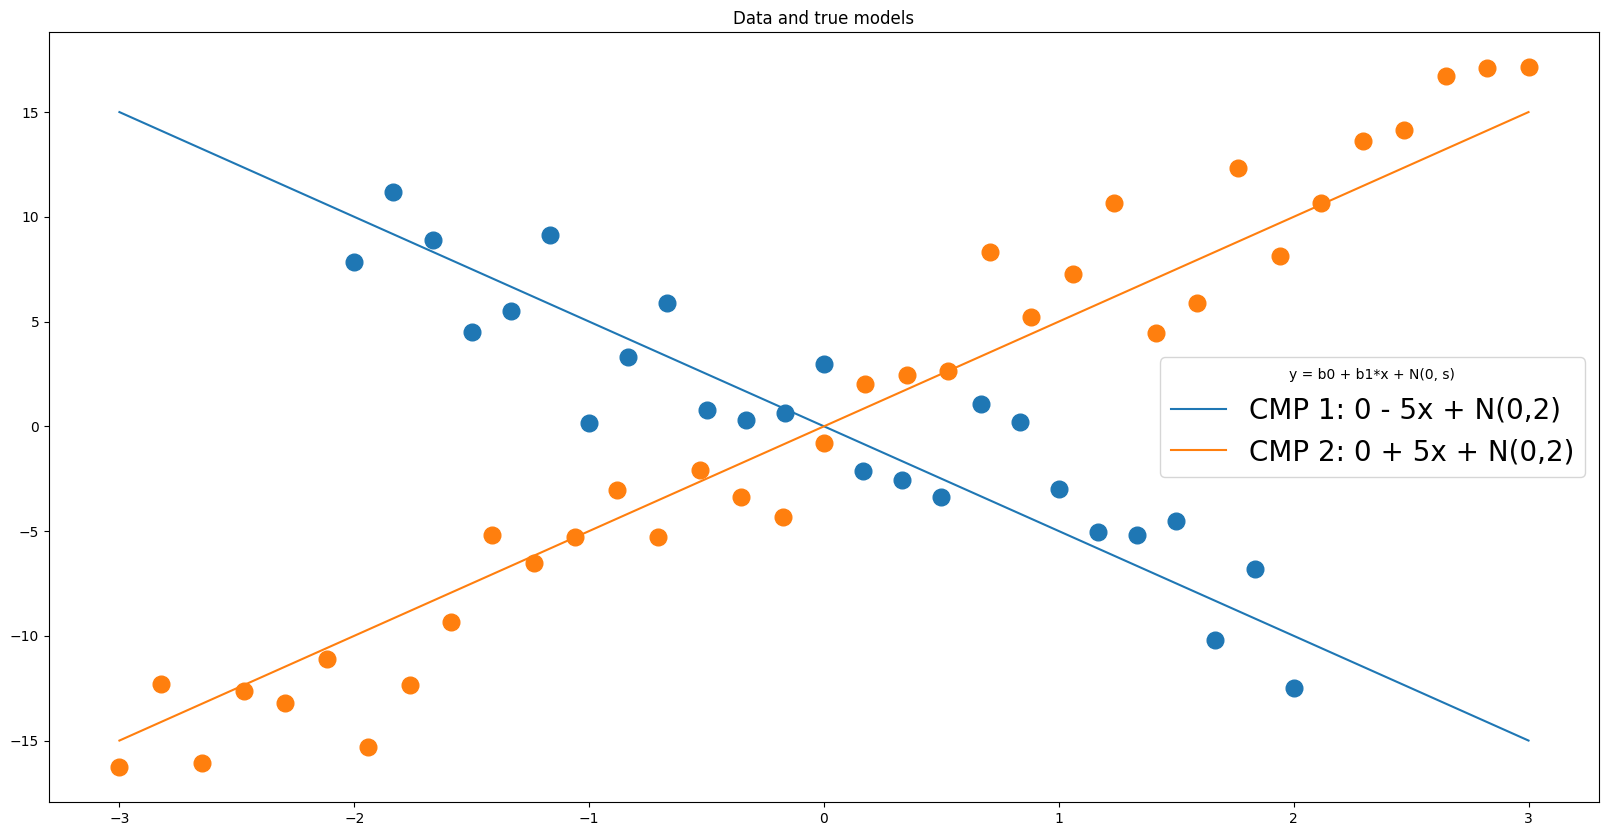

In [7]:
def sign(x):
    if x > 0: 
        return "+"
    else:
        return "-"

def plot_true_model(xs, ys, b0, b1, sigma):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    x_model = np.linspace(-3, 3)
    ax.set_title("Data and true models")

    colors = itertools.cycle(get_cmap(CMAP_NAME).colors)
    for x, y in zip(xs, ys):
        color = next(colors)
        ax.scatter(
            x,
            y,
            s=144,
            marker="o",
            color=color,
        )

    colors = itertools.cycle(get_cmap(CMAP_NAME).colors)
    for icmp, b1_ in enumerate(b1, 1):
        color = next(colors)
        y_model = b0 + b1_ * x_model
        ax.plot(
            x_model,
            y_model,
            linestyle="-",
            color=color,
            label=f"CMP {icmp}: {b0} {sign(b1_)} {np.abs(b1_)}x + N(0,{sigma})",
        )
    ax.legend(fontsize=20, title="y = b0 + b1*x + N(0, s)")
    plt.close()
    return fig
    
fig = plot_true_model((x1, x2), (y1, y2), b0, b1, sigma)
fig


In this exercise we imagine that we do not know which component generated which data points so the plot below shows the data as seen by the model.

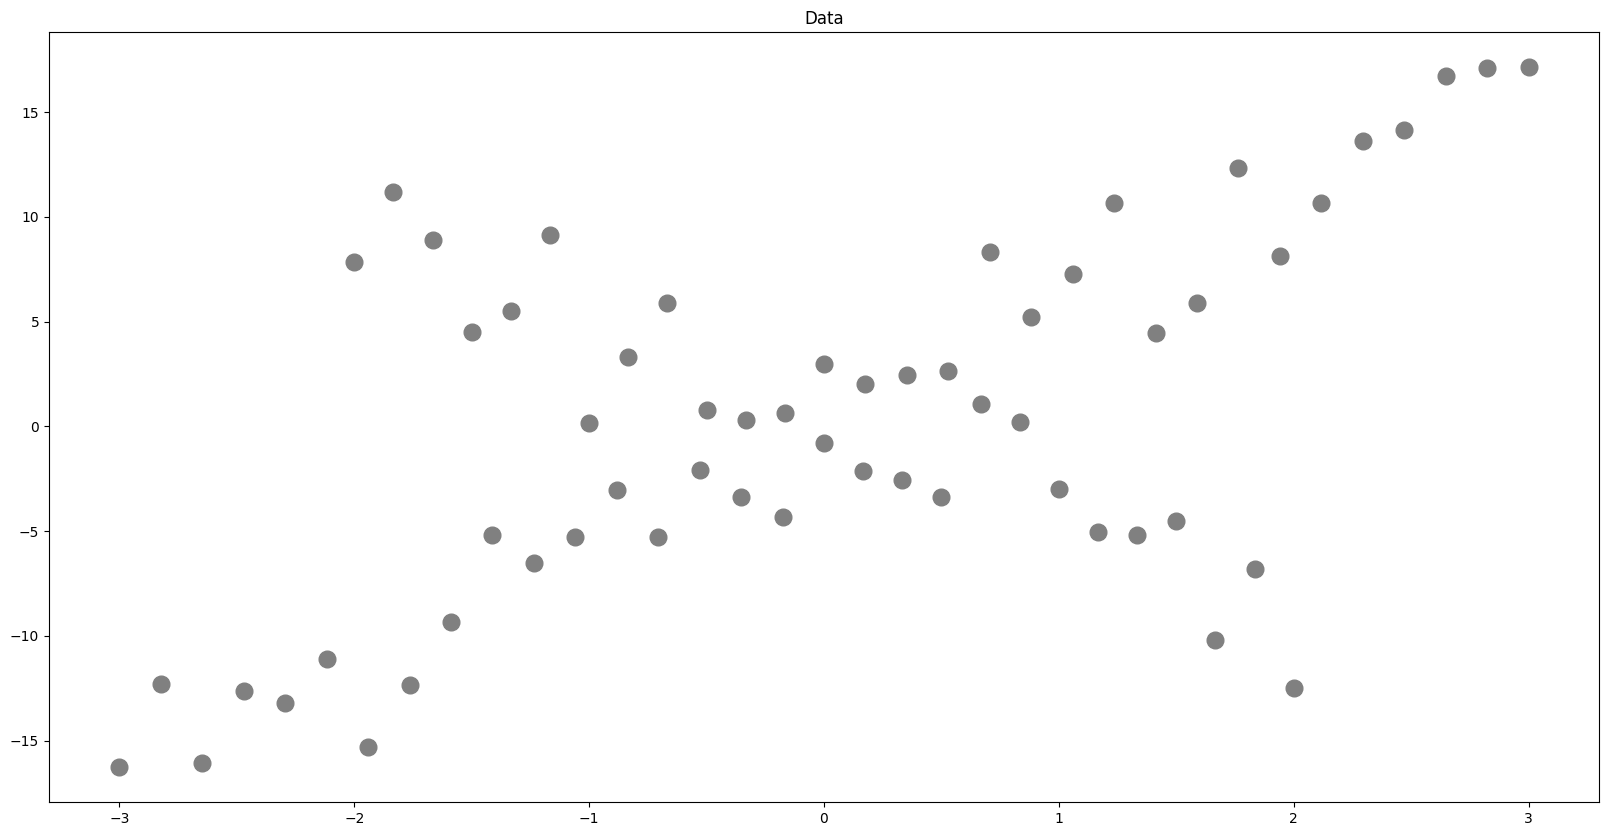

In [8]:
def plot_data(xs, ys):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.set_title("Data")
    for x, y in zip(xs, ys):
        ax.scatter(
            x,
            y,
            s=144,
            marker="o",
            color="gray",
        )
    plt.close()
    return fig

fig = plot_data((x1, x2), (y1, y2))
fig

## Curve fit - known classes

In this section I will analyze date for the two components individually using a curve fitting approach i.e. minimize the square residuals to give the maximum likelihood estimate (MLE) for the model parameters.

In [24]:
def plot_curve_fit(xs, ys):
    fig, axs = plt.subplots(2, 1, figsize=(20, 20))

    colors = itertools.cycle(get_cmap(CMAP_NAME).colors)
    for i, (x, y) in enumerate(zip(xs, ys), 1):
        popt, pcov = curve_fit(model, x, y)

        # Standard errors
        perr = np.sqrt(np.diag(pcov))

        y_predicted = model(x, *popt)

        # sigma
        sigma = np.std(y_predicted - y)
        ss_res = np.sum( np.power(y_predicted - y, 2))
        ss_tot = np.sum( np.power(y - np.mean(y), 2) )

        # coefficient of determinations
        rsq = 1 -ss_res / ss_tot

        print(f"CMP {i}")
        print("popt", popt)
        print("perr", perr)
        print("pcov", np.array2string(pcov, precision=2).replace("\n", ""))
        print("sigma", sigma)
        print("R^2", rsq)
        print()

        color = next(colors)

        sns.regplot(
            x=x,
            y=y,
            ci=95,
            order=1,
            line_kws={
                "label": f"CMP{i}. MLE={popt} (σ={sigma})",
                "color": color,
            },
            scatter_kws={
                "s": 144,
            },
            seed=1,
            label=f"CMP{i} data.",
            truncate=False,
            color=color,
            ax=axs[0],
        )

        plot_parameters(popt, pcov, axs[1], f"CMP{i}", nstds=[2], color=color)

    axs[0].set_xlabel("x", fontsize=NORMAL_FONTSIZE)
    axs[0].set_ylabel("y", fontsize=NORMAL_FONTSIZE)
    axs[0].legend(fontsize=20)

    axs[1].legend(fontsize=20)
    axs[1].set_xlabel("b0", fontsize=NORMAL_FONTSIZE)
    axs[1].set_ylabel("b1", fontsize=NORMAL_FONTSIZE)

    for ax in axs.flat:
        ax.tick_params(axis="both", which="major", labelsize=NORMAL_FONTSIZE)

    fig.suptitle("MLE parameters inferred from true classes")
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.close()
    return fig


Here's the MLEs for the two components.

In [25]:
fig = plot_curve_fit((x1, x2), (y1, y2))

CMP 1
popt [ 0.28020561 -4.49188226]
perr [0.48690263 0.40512748]
pcov [[2.37e-01 1.09e-10] [1.09e-10 1.64e-01]]
sigma 2.335102980159669
R^2 0.8423949114488264

CMP 2
popt [0.1190518  5.64646829]
perr [0.35775744 0.20073186]
pcov [[ 1.28e-01 -3.79e-09] [-3.79e-09  4.03e-02]]
sigma 2.0551602386671677
R^2 0.9599642635274688



Note that when fitting the components individually we cannot constrain the intercepts to be the same and I have omitted such a data fit in this analysis. In the first figure below I have shown the data, the MLE for the parameters as well as the confidence interval (uncertainty of the mean outcome). In the second plot the parameter covariance matrix is illustrated and shows that $b_0$ and $b_1$ essentially have zero correlation.

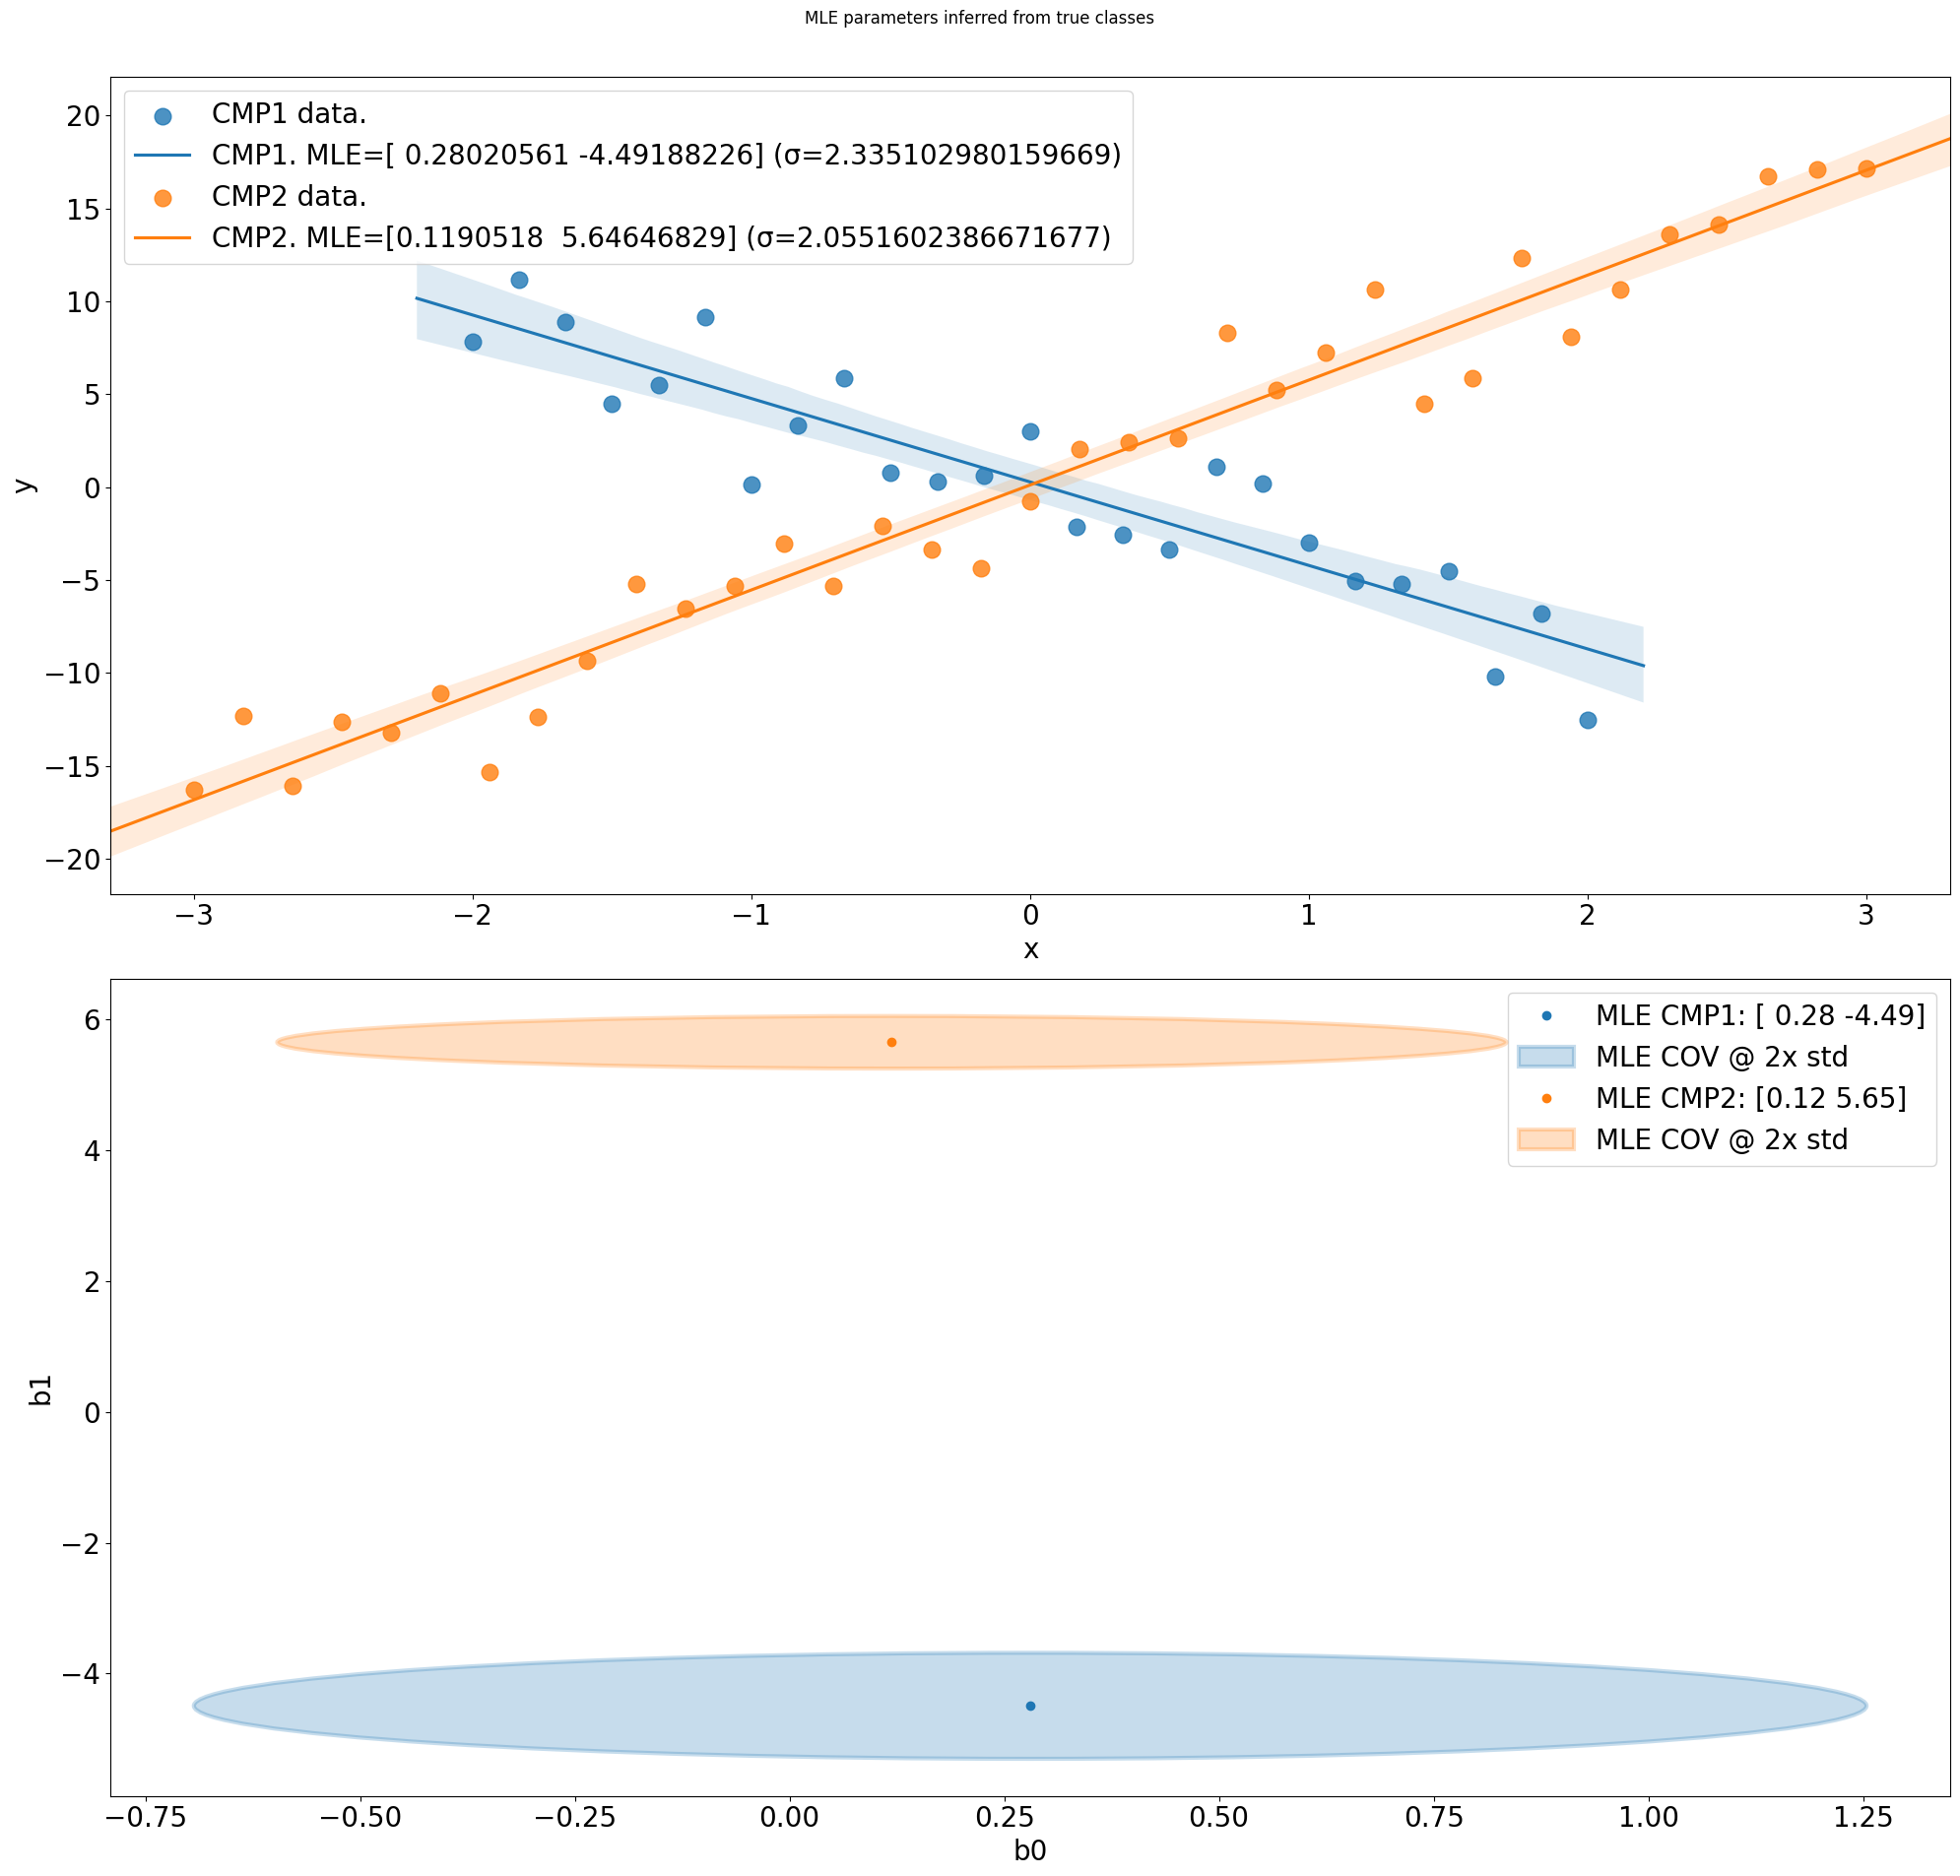

In [11]:
fig

## Bayesian inference - known classes

Since we will be using a Bayesian model to fit a regression mixture model, I will briefly go through a Bayesian inference that is more or less equivalent to the curve fitting approach above. 

In the function below I define a linear model explicitly i.e. without using `pymc3` shorthand notation to better understand how the model is composed of priors for the model parameters and a likelihood distribution. With the model I then create the posterior distribution by sampling. 

In [12]:
def fit_c1(
    x,
    y,
    return_inferencedata: bool = False,
    nsteps: int = 10000,
    nchains: int = 4
):
    """One-component "mixture" """
    model = pm.Model()
    with model:
        b0 = pm.Normal("b0", 0, sigma=20)
        b1 = pm.Normal("b1", 0, sigma=20)
        y_est = b0 + b1 * x
        sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
        likelihood = pm.Normal("y", mu=y_est, sigma=sigma, observed=y)

        trace = pm.sample(
            nsteps, return_inferencedata=return_inferencedata, chains=nchains
        )
        return trace, model


The function below plots and summarizes the posterior distribution in various ways.

In [13]:
def plot_ppc(idata, model, x, ax, samples: Optional[int] = None, kind: str = "kde", plot_mean: bool = True):
    """Add ppc plots to the ax"""

    hdi_prob = az.rcParams["stats.hdi_prob"]

    with model:
        ppc = pm.sample_posterior_predictive(
            idata, var_names=["b0", "b1", "y", "sigma"], random_seed=RANDOM_SEED, samples=samples,
        )

    label = f"Mean outcome {hdi_prob*100} % HDI"
    b1_vals = ppc["b1"]
    print("NDIM", b1_vals.ndim)
    print("SHAPE", b1_vals.shape)
    if b1_vals.ndim > 1:
        b1_vals = ppc["b1"].transpose() # iterate the columns
    else:
        b1_vals = [b1_vals]

    for icmp, b1 in enumerate(b1_vals, 1): 
        b0 = ppc["b0"]
        mu_pp = (b0 + b1 * x[:, None]).T
        # y_pp = mu_pp + ppc["sigma"] + np.random.normal(loc=0, scale=sigma, size=size1)

        if plot_mean:
            ax.plot(x, mu_pp.mean(0), color="black", label=f"Mean outcome CMP{icmp} [{b0.mean():5.2}; {b1.mean():5.2}]", alpha=1.0, zorder=100)

        az.plot_hdi(
            x,
            mu_pp,
            ax=ax,
            color="magenta",
            fill_kwargs={
                "alpha": 0.2,
                "label": label, 
            },
        )
        label = "" # only add one label
        plt.close()

    if kind == "kde":
        az.plot_hdi(
            x,
            ppc["y"], # this is for all classes
            ax=ax,
            color="gray",
            fill_kwargs={
                "alpha": 0.2,
                # "color": "0.2",
                "label": f"Outcome {hdi_prob*100} % HDI",
            },
        )
    elif kind == "bar":
        y = ppc["y"]
        two_sided = 0.5*(1 - hdi_prob)
        q = (two_sided, 1 - two_sided)
        for ix, x_ in enumerate(x):
            y_ = y[:, ix]
            y_minmax = np.quantile(y_, q=q)
            h = ax.vlines(x_, y_minmax[0], y_minmax[1], color="gray", linewidth=2, alpha=0.2)
            plt.close()
        h.set_label(f"Outcome {hdi_prob*100} % HDI")
        
    elif kind == "scatter":
        y = ppc["y"]
        n_sample = y.shape[0]
        ax.plot(
            np.tile(x, (n_sample, 1)).flat,
            ppc["y"].flat, # this is for all classes
            color="lightgray",
            marker="o",
            alpha=0.2,
            linewidth=0,
            zorder=-100,
        )
    else:
        raise NotImplementedError("Unknown ppc 'kind'")

    plt.close()

    ax.set_xlabel("Predictor")
    ax.set_ylabel("Outcome")
    ax.set_title("Posterior predictive checks")
    ax.legend(ncol=2, fontsize=12)
    return fig


def plot_bayesian_fit(xs, ys, nsteps=25000, do_ppc: bool = True):
    # Bayesian inference for the true classes
    point_estimate = "mean"
    var_names = ["b0", "b1", "sigma"]
    var_names_pairs = ["b0", "b1"]

    fig_posterior, axs = plt.subplots(len(xs), len(var_names), figsize=(20, 20))
    fig_pair, axs_pair = plt.subplots(len(xs), 1, figsize=(20, 20))

    if do_ppc is not None:
        fig_gppc, axs_gppc = plt.subplots(len(xs), 1, figsize=(20, 20))
        fig_model_ppc, axs_model_ppc = plt.subplots(len(xs), 1, figsize=(20, 20))
    else:
        fig_gppc = None
        fig_model_ppc = None

    data = []

    for i, (x, y) in enumerate(zip(xs, ys)):

        trace, model = fit_c1(
            x,
            y,
            nsteps=nsteps,
            return_inferencedata=True,
        )

        data.append(trace)

        az.plot_posterior(
            trace,
            var_names=var_names,
            point_estimate=point_estimate,
            ax=axs[i, :],
        )
        plt.close()


        az.plot_pair(
            trace,
            var_names=var_names_pairs,
            kind="kde",
            point_estimate="mean",
            divergences=True,
            textsize=18,
            ax=axs_pair[i],
        )
        plt.close()


        if do_ppc:
            # Scatter point
            axs_model_ppc[i].plot(x, y, "o", color="gray", ms=8, label="Data", zorder=100)

            # ppc
            plot_ppc(trace, model, x, axs_model_ppc[i])

    return data, fig_posterior, fig_pair, fig_gppc, fig_model_ppc


Now let us run the analysis

In [14]:
do_ppc = True
data_known_cls, fig_posterior, fig_pair, fig_gppc, fig_mppc = plot_bayesian_fit(
    (x1, x2),
    (y1, y2),
    nsteps=1000,
    do_ppc=do_ppc,
)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b1, b0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


NDIM 1
SHAPE (4000,)


/home/jacob/.local/share/virtualenvs/misc-VgmIW_Et/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b1, b0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


NDIM 1
SHAPE (4000,)


/home/jacob/.local/share/virtualenvs/misc-VgmIW_Et/lib/python3.8/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Below the marginal distributions of `b0` (intercept), `b1` (slope) and `sigma` (random error) are shown along with a point estimate for the mean and the 94 % highest density interval (HDI). These estimates are quite close to the results obtained from the curve fit.

CMP1: b1 = -4.485 [-5.262; -3.617]
CMP2: b1 = 5.646 [5.239; 6.03]


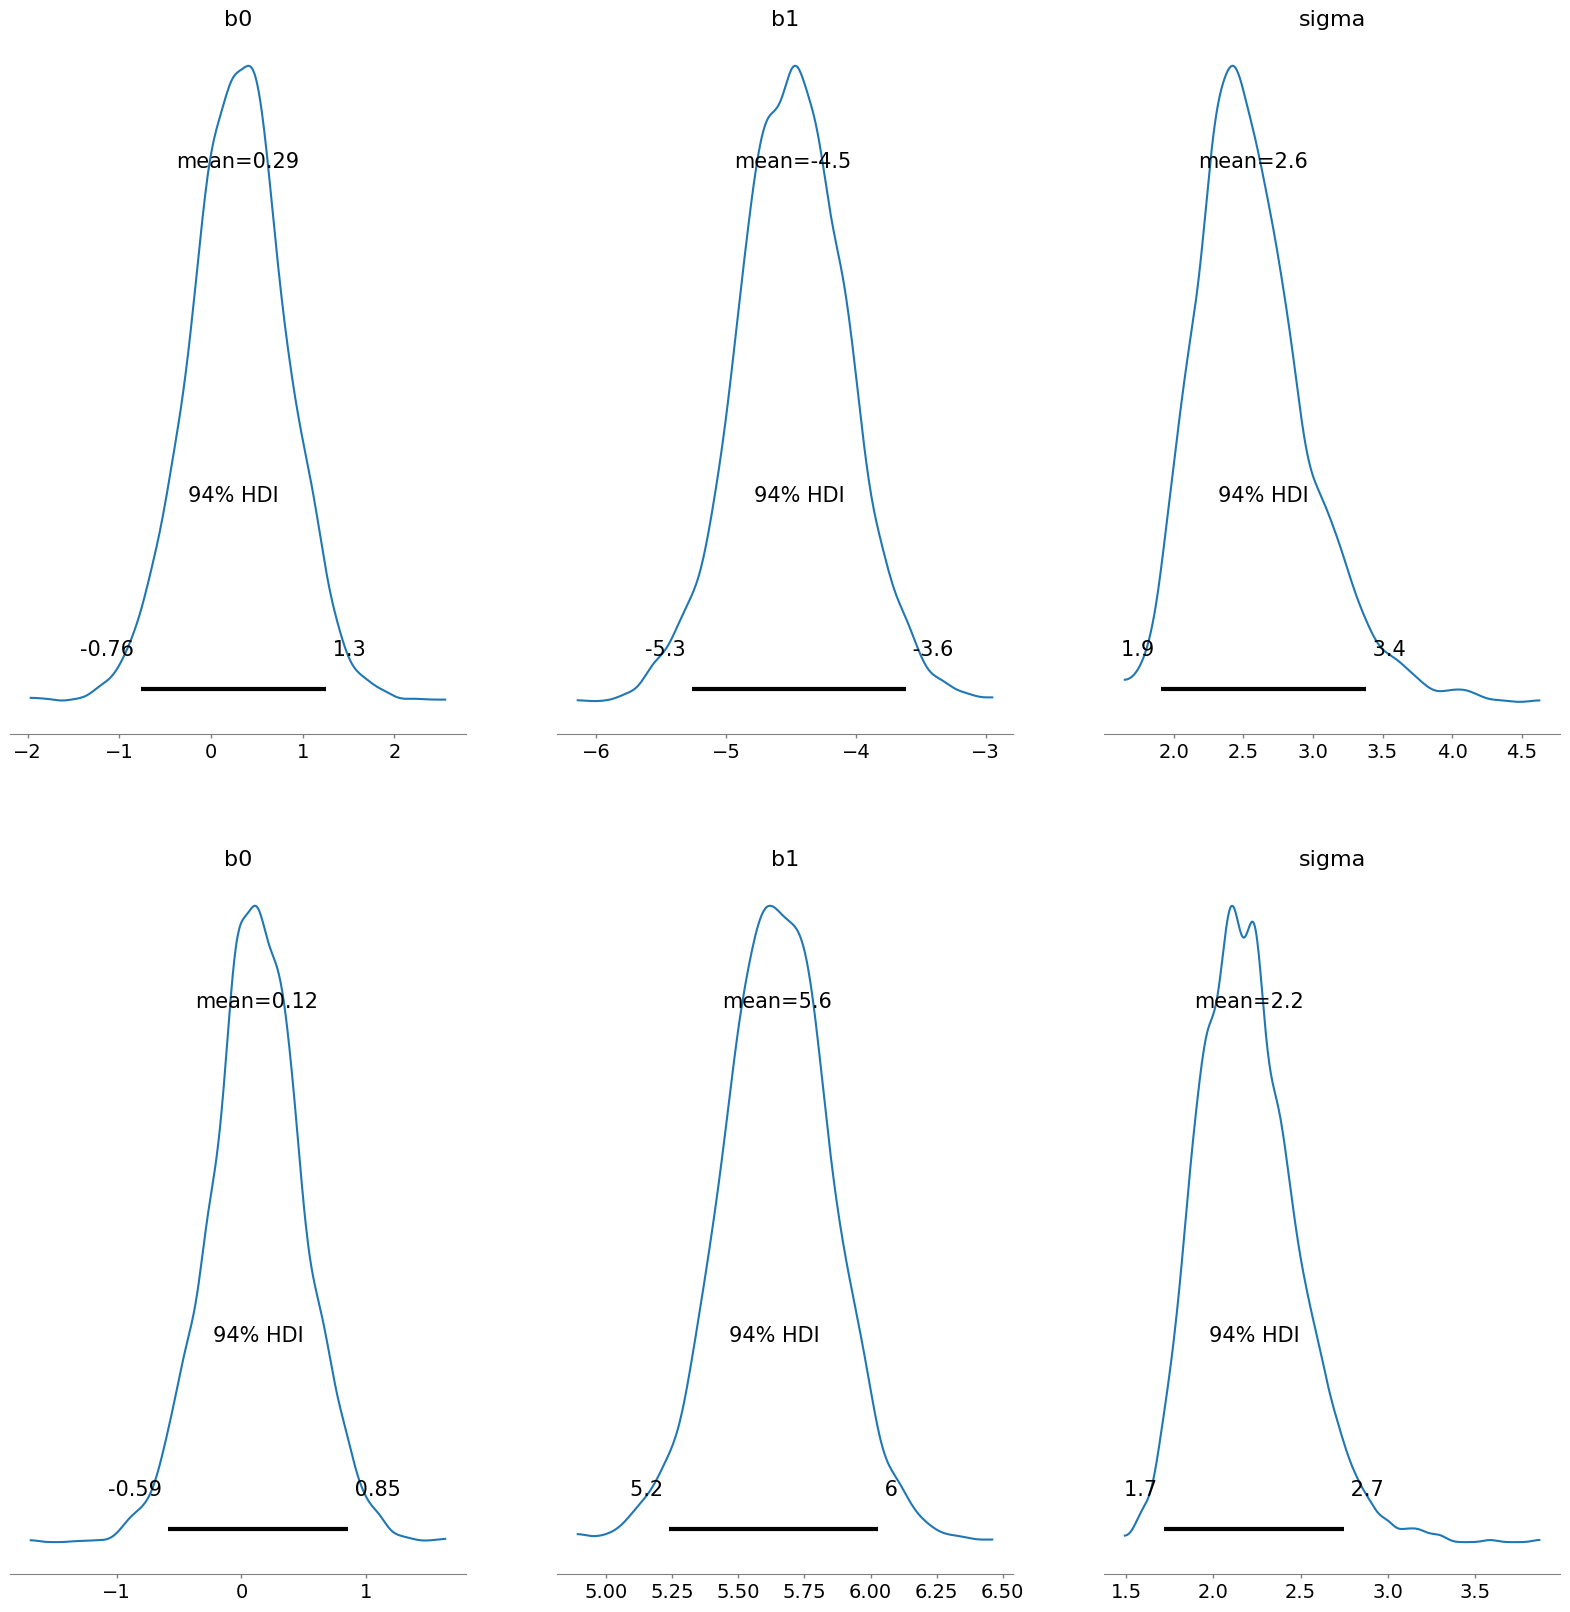

In [18]:
# for each (known) component calculate point estimates
hdi_prob = az.rcParams["stats.hdi_prob"]

for icmp, data in enumerate(data_known_cls, 1):
    post = data.posterior
    b0_mean_known_cls = post.mean(dim=['chain', 'draw'])["b0"].to_numpy()
    b1_mean_known_cls = post.mean(dim=['chain', 'draw'])["b1"].to_numpy()
    sigma_mean_known_cls = post.mean(dim=['chain', 'draw'])["sigma"].to_numpy()

    df = az.summary(data, var_names=["b0", "b1", "sigma"], hdi_prob=hdi_prob)
    par_str = f'b1 = {df["mean"]["b1"]} [{df["hdi_3%"]["b1"]}; {df["hdi_97%"]["b1"]}]'
    print(f"CMP{icmp}:", par_str)

fig_posterior

As for the curve fit we can illustrate how `b0` and `b1` covary for the two components. The black point mark the mean.

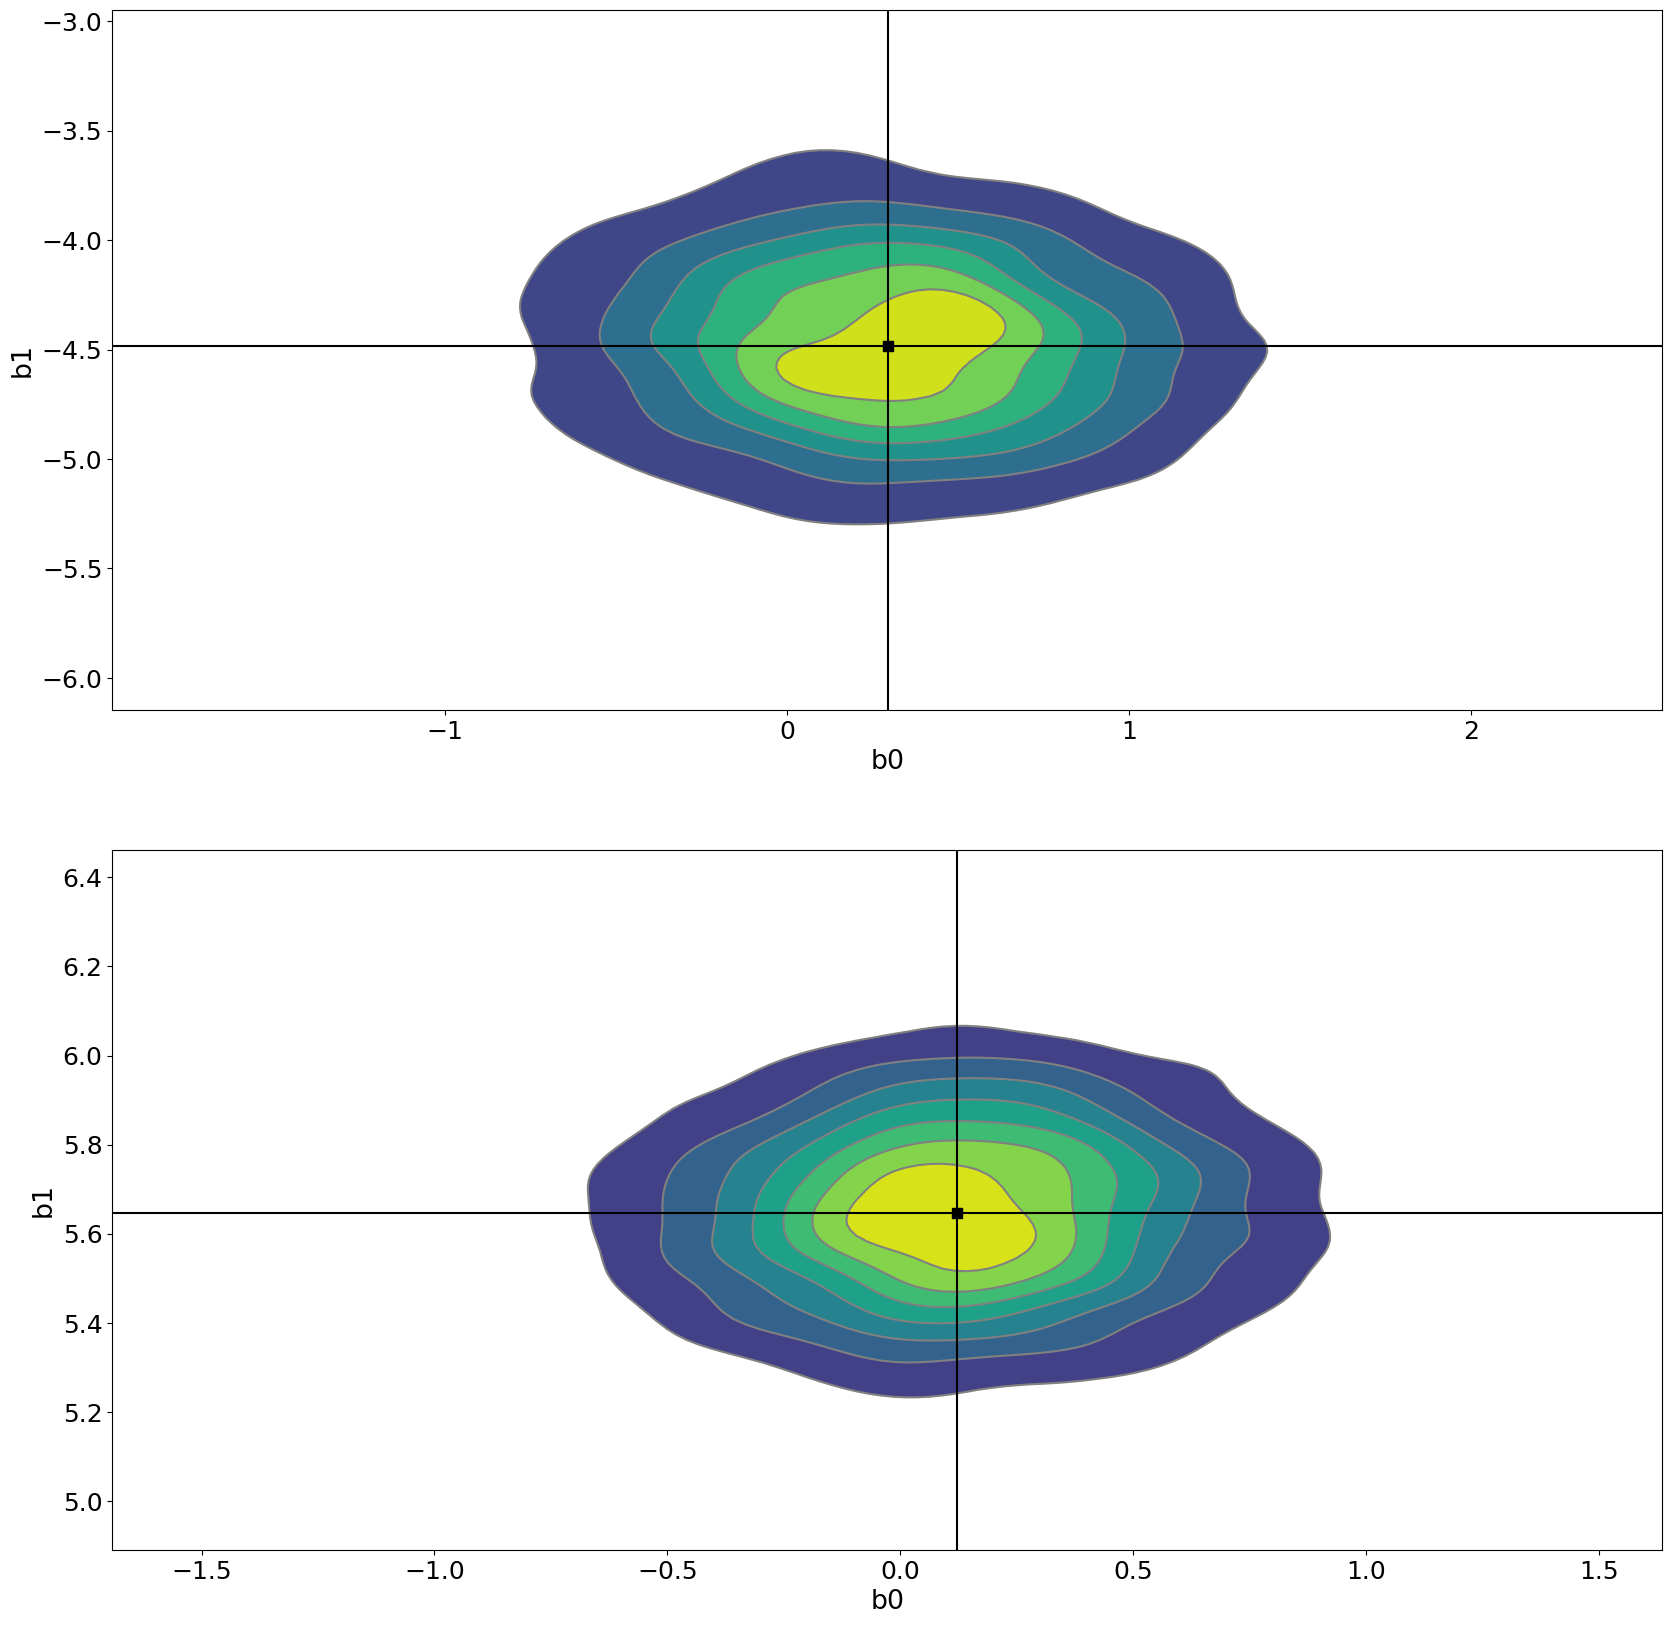

In [19]:
fig_pair

The plot below illustrates how samples from the posterior parameter distribution propagate through the model to give a distribution of outcomes. These outcomes are summarized as HDIs for the mean outcome and the outcome. The data is also included to verify that the parameter estimates are reasonable.

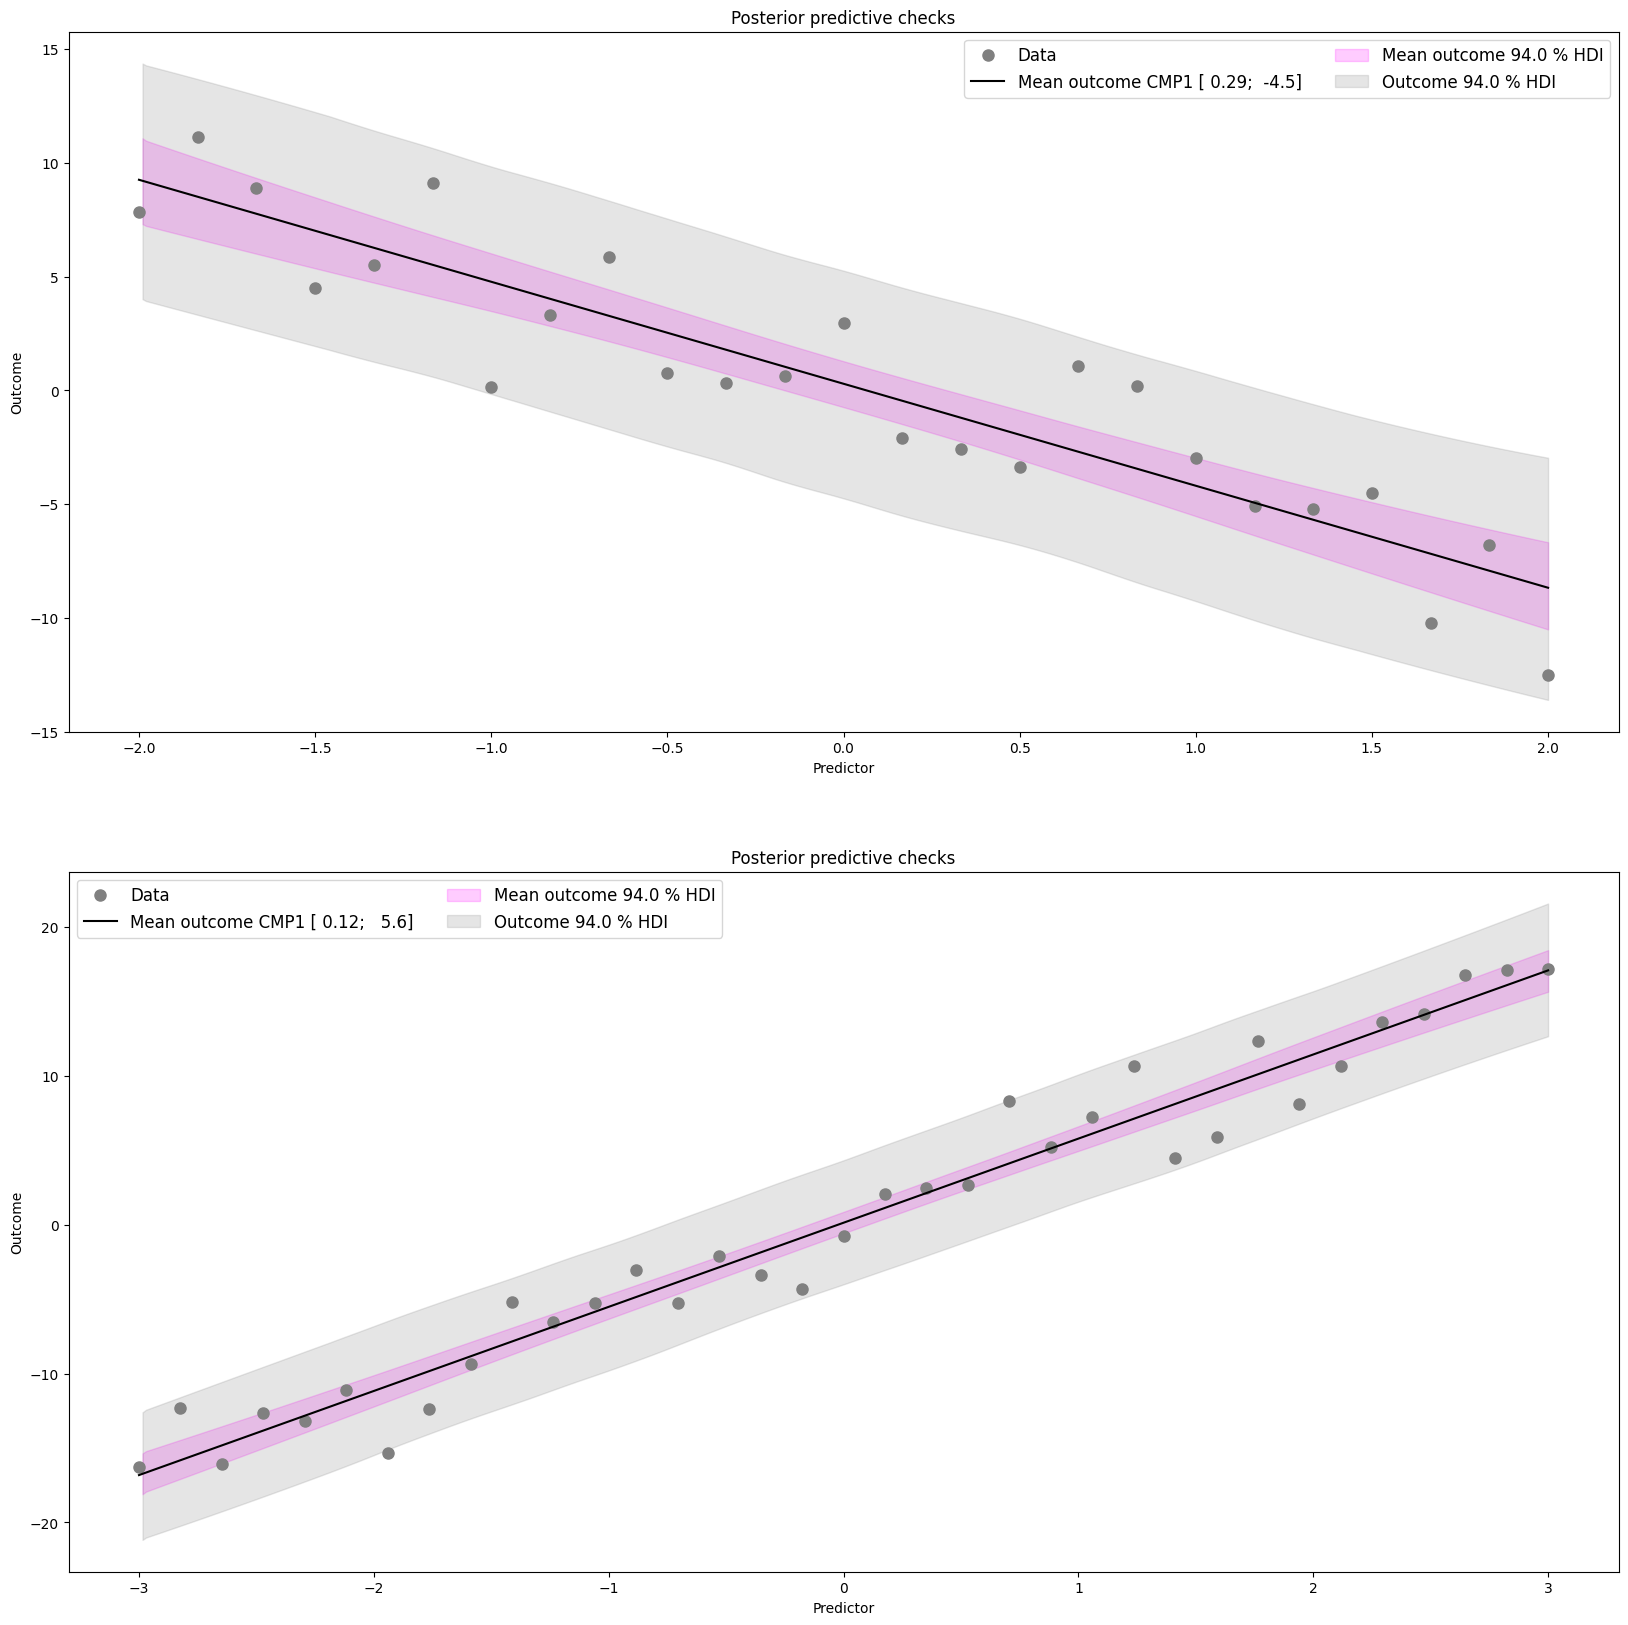

In [20]:
fig_mppc

## Bayesian inference - unknown classes

In this section I will attempt to infer subpopulation membership for the data points as well as the the subpopulation model parameters using a finite linear mixture model. First I will run with a uninformative Dirichlet prior for the latent classes, which will tend to populate all the specified classes. Subsequently, I will adjust the Dirichlet prior in such a way that the category weights in posterior would indicate how many subpopulations describe the data and regard the specified number of components as an upper bound.

### Specified number of mixture components 

In this [appendix](#dirichlet-distribution) I have illustrated the uninformative Dirichlet prior Dirichlet(1, 1, 1). Gelman et al. [[3]](#3) notes that this prior will tend to fill out the pre-specified number of components. In the `pymc3` model this prior is specified like so

```py
p = pm.Dirichlet("p", a=np.ones(n_components), shape=n_components)
```

In the following sections I will qualitatively evaluate a 1-component, a 2-component and a 3-component model. Then I will attempt to compare these model more quantitatively. These three models are enough to illustrate some interesting points regarding this finite mixture model.

To accommodate the label swapping (non-identifiability) problem caused by the symmetry I enforce that the slopes should be ordered.

```py
b1 = pm.Normal(
    ...,
    transform=tr.ordered
    testval=np.linspace(-1, 1, n_components),
)
```

I am not sure how `pymc3` handles the ordering, but in my experience the built-in ordering works much better than manually enforcing the order something like this.

``` py
switches = tt.switch(b1[1] - b1[0] < 0, -np.inf, 0)
for icmp in range(1, n_components - 1):
    switches += tt.switch(b1[icmp + 1] - b1[icmp] < 0, -np.inf, 0)

order_slopes_potential = pm.Potential(
    "order_slopes_potential",
    switches,
)
```

Note that Gelman et al. [[3]](#3) p536 discourages ordering in favor of adjusting the prior which I will attempt later in this note.

#### Code

The function below can fit `n_components` linear components to data using different strategies for the Dirichlet prior and the component minimum weights. The latter feature will not be used. The model allows each component to have a different slope, but the intercept and random noise is the same in all components.

In [82]:
def fit_cn(
    x,
    y,
    n_components,
    return_inferencedata: bool = False,
    favor_few_components: bool = True,
    p_min: Optional[float] = 0.1,
    nsteps: int = 10000,
):
    """
    Fit n components
    Modified from https://docs.pymc.io/en/v3/pymc-examples/examples/mixture_models/gaussian_mixture_model.html
    """
    assert n_components >= 2, "Must have more than 1 component"
    size = x.size
    model = pm.Model()
    with model:
        # cluster sizes

        if favor_few_components:
            # prior that should favor populating few dominant components (Gelman et al p 536)
            p = pm.Dirichlet(
                "p", a=np.ones(n_components) / n_components, shape=n_components
            )
        else:
            # fill all components
            p = pm.Dirichlet("p", a=np.ones(n_components), shape=n_components)

            if p_min is not None:
                # ensure all clusters have some points
                p_min_potential = pm.Potential(
                    "p_min_potential", tt.switch(tt.min(p) < p_min, -np.inf, 0)
                )

        b0 = pm.Normal("b0", mu=0, sd=10)  # Intercept
        b1 = pm.Normal(
            "b1",
            mu=0,
            sd=100,
            shape=n_components,
            transform=tr.ordered, # Deal with identifiability by enforcing a order in slopes
            testval=np.linspace(-1, 1, n_components),
        )
        sigma = pm.Uniform("sigma", 0, 20)  # Noise

        # latent cluster of each observation
        category = pm.Categorical("category", p=p, shape=size)

        b1_ = pm.Deterministic("b1_", b1[category])  # Choose b1 based on category

        mu = b0 + b1_ * x  # Expected value of outcome

        # Likelihood
        likelihood = pm.Normal("y", mu=mu, sd=sigma, observed=y)

    # fit model
    with model:
        step1 = pm.Metropolis(vars=[p, b0, b1, sigma])
        step2 = pm.CategoricalGibbsMetropolis(vars=[category])
        trace = pm.sample(
            nsteps,
            step=[step1, step2],
            tune=int(0.2 * (nsteps)),
            progressbar=True,
            return_inferencedata=return_inferencedata,
        )
        return trace, model


Here the fitter is wrapped to also accommodate the 1-component fitter shown previously.

In [83]:
def fit(
    x,
    y,
    n_components: int,
    return_inferencedata: bool = False,
    favor_few_components: bool = True,
    p_min: Optional[float] = 0.1,
    nsteps: int = 10000,
):
    if n_components == 1:
        data, model = fit_c1(
            x,
            y,
            return_inferencedata=return_inferencedata,
            nsteps=nsteps,
        )
    elif n_components >= 2:
        data, model = fit_cn(
            x,
            y,
            n_components,
            favor_few_components=favor_few_components,
            return_inferencedata=return_inferencedata,
            p_min=p_min,
            nsteps=nsteps,
        )

    return data, model


Here's some code for saving and loading simulations.  

In [1]:
def filename_az(ncmp, nsteps, ffc):
    return f"az_nc={ncmp}_ns={nsteps}_ffc={ffc}.nc"


def filename_pymc(ncmp, nsteps, ffc):
    return f"pymc_nc={ncmp}_ns={nsteps}_ffc={ffc}.pkl"


def save_model(model, filepath):
    with open(filepath, 'wb') as fh:
        pickle.dump(model, fh)

def load_model(filepath):
    with open(filepath, 'rb') as fh:
        model = pickle.load(fh)
    return model

Here's some code for postprocessing and plotting.

In [287]:
def process_posterior(posterior):
    """Calculate most frequent category for each point and 
    calculate the probability for that category for each point
    """
    cat = posterior["category"].to_numpy()
    cat = cat.reshape(-1, cat.shape[-1])
    n_draw = cat.shape[0]
    print(f"Total number of draws {n_draw}")

    # for eaach point count number of times it's classed (nclasses x npoints)
    a = np.apply_along_axis(np.bincount, 0, cat, minlength=np.max(cat) + 1)
    weight = np.sum(a, axis=1) / np.sum(a)
    print(f"Components weights: {weight}")

    # probability for each point belonging to each category
    p_cat_all = a / n_draw
    
    # most prevalent cluster
    cat = np.argmax(a, axis=0)

    # Number of samples in most prevalent cluster
    n_cat = np.array([a[c, i] for i, c in enumerate(cat)])

    # probability of most likely category
    p_cat = n_cat / n_draw
    unique, count = np.unique(cat, return_counts=True)
    print("Filled classes", unique)
    print("Data points predominantly assigned to each class", count)
    # print(p_cat[cat == 1])
    return cat, p_cat, p_cat_all

def pie_scatter(xs, ys, ratios, sizes, size_center, colors, ax):
    assert sum(ratios) <= 1, 'sum of ratios needs to be < 1'

    markers = []
    # previous = 0
    previous = np.pi / 2 # start at noon 
    npoints = 500
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this =  previous - 2 * np.pi * ratio # counter clockwise
        points = np.linspace(previous, this, npoints)
        x  = [0] + np.cos(points).tolist()
        y  = [0] + np.sin(points).tolist()
        xy = np.column_stack([x, y])
        previous = this
        # markers.append({'marker': xy, 's': np.abs(xy).max()**2 * np.array(sizes), 'facecolor': color})
        markers.append({'marker': xy, 's': np.array(sizes), 'facecolor': color})

    # scatter each of the pie pieces to create pies
    for marker in markers:
        ax.scatter(xs, ys, **marker)
    ax.scatter(xs, ys, s=size_center, color="w")


def plot_ncomp(xs, ys, b0, b1, cat=None, p_cat=None, p_cat_all=None):
    fig, ax = plt.subplots(figsize=(16, 8), dpi=180)
    size_true = 144
    size_pred = size_true*0.5
    size_pie = size_true*3.5
    xmin = 1e12
    xmax = -xmin

    # For transforming cluster probability to alpha
    if cat is not None:
        amin, amax = 0.25, 1
        pmin, pmax = min(np.min(p_cat), 0.5), 1
        slope = (amax - amin) / (pmax - pmin)

    colors = itertools.cycle(get_cmap(CMAP_NAME).colors)
    # Plot data and true categories
    for icmp, (x, y) in enumerate(zip(xs, ys), 1):
        ax.scatter(x, y, s=size_true, facecolors="none", edgecolors=next(colors), label=f"Data CMP {icmp}", zorder=10000)
        xmin = min(xmin, min(x))
        xmax = max(xmax, max(x))

    if p_cat_all is not None:
        # pie chart for each point visualizing the category prevalence
        # https://stackoverflow.com/questions/54541081/how-to-plot-a-donut-chart-around-a-point-on-a-scatterplot
        x_all = np.concatenate(xs)
        y_all = np.concatenate(ys)
        n_cat = p_cat_all.shape[0]
        pie_colors = get_cmap(CMAP_NAME).colors[:n_cat]
        for x, y, frc in zip(x_all, y_all, p_cat_all.transpose()):
            pie_scatter([x], [y], frc, [size_pie], size_true*1.5, pie_colors, ax)


    if cat is not None:
        categories = np.unique(cat)
        x_all = np.concatenate(xs)
        y_all = np.concatenate(ys)
        colors = itertools.cycle(get_cmap(CMAP_NAME).colors)
        for cat_id in categories:

            # Set face alpha to the class probability
            p = p_cat[cat == cat_id]
            alpha = slope * (p - pmin) + amin
            alpha = np.where(alpha < 0, 0, alpha)

            color = next(colors)
            ax.scatter(
                x_all[cat == cat_id],
                y_all[cat == cat_id],
                s=size_pred,
                facecolors=color,
                alpha=alpha,
                edgecolors="none",
                # label=f"Predicted CMP {cat_id}"
            )

            # Fake data point used to set the alpha to 1 in the legend 
            ax.scatter(
                [np.NaN],
                [np.NaN],
                s=size_pred,
                facecolors=color,
                alpha=1.0,
                edgecolors="none",
                label=f"Predicted CMP {cat_id + 1}"
            )

    colors = itertools.cycle(get_cmap(CMAP_NAME).colors)
    x_pred = np.linspace(xmin, xmax, 10)
    for icmp, b1_ in enumerate(np.atleast_1d(b1), 1):
        y_pred = model(x_pred, b0, b1_)
        ax.plot(x_pred, y_pred, "-", color=next(colors), label=f"Model CMP {icmp} [{b0:5.2}, {b1_:5.2}]")

    leg = ax.legend()

    # alpha is reset when I add more data to the fig?!?
    # for lh in leg.legendHandles: 
    #     lh.set_alpha(1)

    return fig


#### Inference

Now we are ready to generate the inference data.

In [21]:
n_components = [1, 2, 3]
nsteps = 20000

# Set the latent class prior to Direchlet(ones)  
ffc = False

In [84]:
for ncmp in n_components:
    data, pymc_model = fit(
        x,
        y,
        ncmp,
        favor_few_components=ffc,
        nsteps=nsteps,
        return_inferencedata=True,
    )

    # Save data to disk
    filepath = TMP_PATH.joinpath(filename_az(ncmp, nsteps, ffc))
    filepath.unlink() 
    az.to_netcdf(data, filepath)

    # Save the model in case we want to do e.g. a posterior predictive check 
    filepath = TMP_PATH.joinpath(filename_pymc(ncmp, nsteps, ffc))
    save_model(pymc_model, filepath)



Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [sigma]
>>Metropolis: [b1]
>>Metropolis: [b0]
>>Metropolis: [p]
>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 4_000 tune and 20_000 draw iterations (16_000 + 80_000 draws total) took 171 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [sigma]
>>Metropolis: [b1]
>>Metropolis: [b0]
>>Metropolis: [p]
>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 4_000 tune and 20_000 draw iterations (16_000 + 80_000 draws total) took 165 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Now I load the inference data and plot the marginal posteriors for `b0` and `b1`. The latter will have as many elements as there are mixture components.

#### Analysis: 2 components

Let us start by looking at the posterior for the 2-component model. 

b0 mean 0.1641450559082887
b1 mean [-4.66061889  5.57202607]
sigma mean 2.4072699263657635

results from know classes
b0 0.28 [-0.73; 1.3]
b1 -4.5 [-5.3; -3.7]
b1 5.6 [5.2; 6.0]


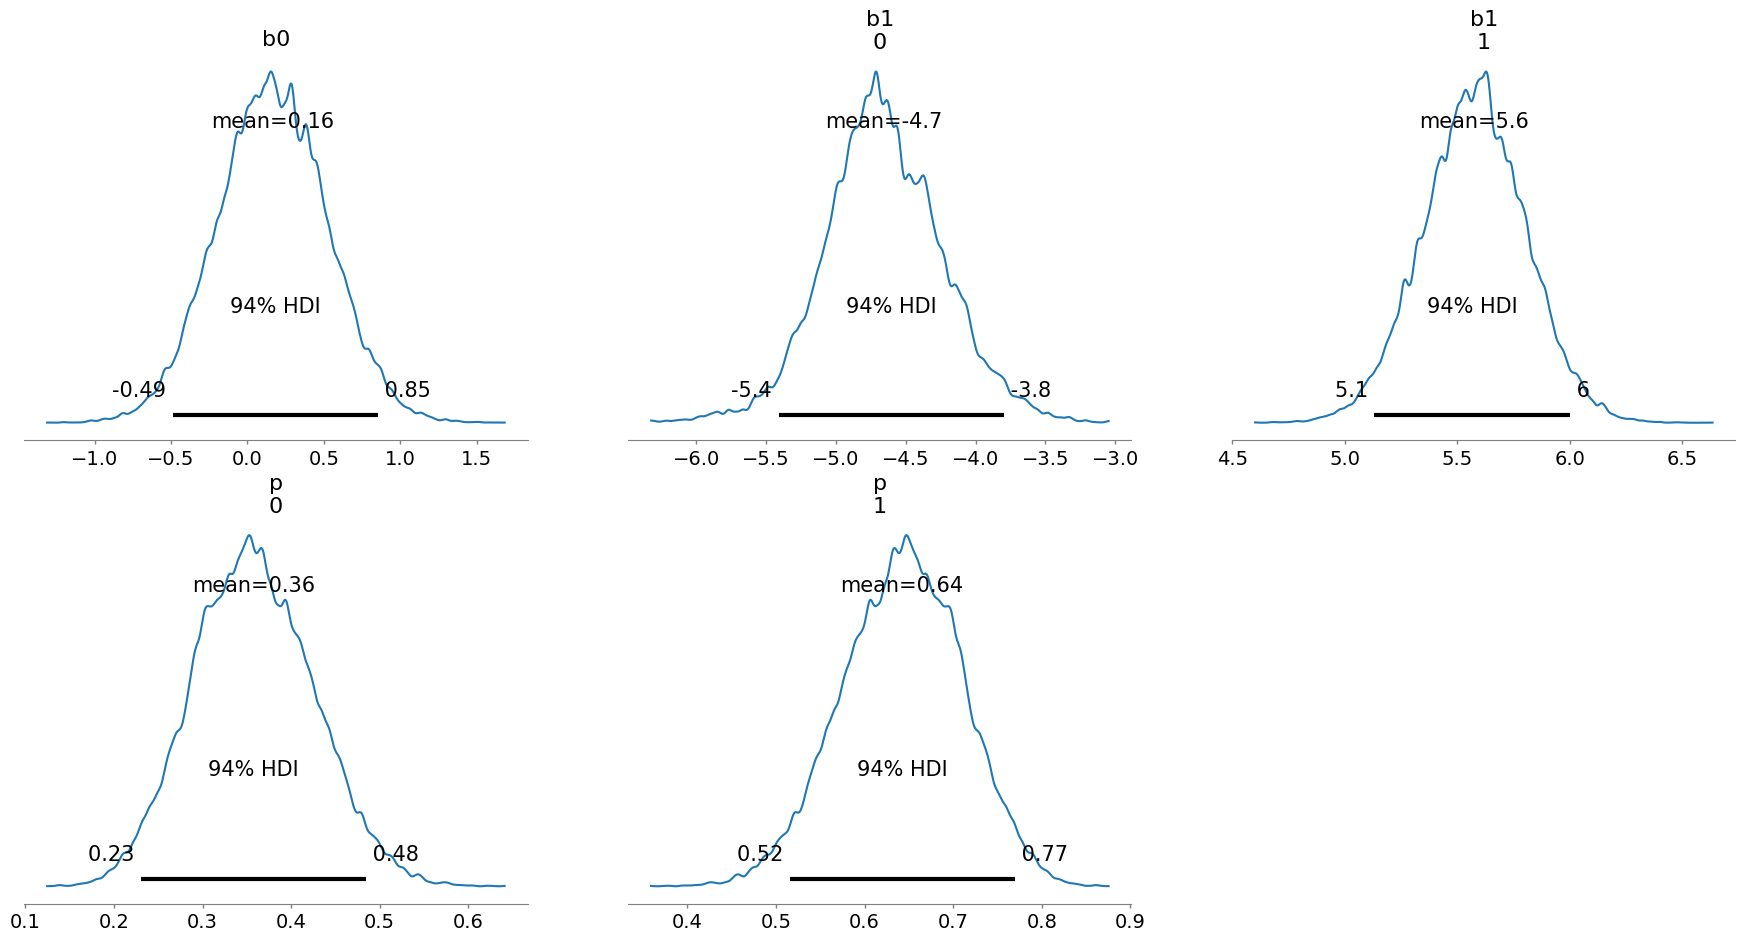

In [283]:
point_estimate = "mean"
var_names = "b0", "b1", "p"
ncmp = 2
data2 = az.from_netcdf(TMP_PATH.joinpath(filename_az(ncmp, nsteps, ffc)))
az.plot_posterior(
    data2,
    var_names=var_names,
    point_estimate=point_estimate,
);

# Calculate point estimates
post = data2.posterior
b0_mean = post.mean(dim=['chain', 'draw'])["b0"].to_numpy()
b1_mean = post.mean(dim=['chain', 'draw'])["b1"].to_numpy()
sigma_mean = post.mean(dim=['chain', 'draw'])["sigma"].to_numpy()

print("b0 mean", b0_mean)
print("b1 mean", b1_mean)
print("sigma mean", sigma_mean)

print("\nresults from know classes")
print("b0 0.28 [-0.73; 1.3]")
print("b1 -4.5 [-5.3; -3.7]")
print("b1 5.6 [5.2; 6.0]")


Both the mean value and the HDIs are in fair agreement with the results obtained [above](#bayesian-inference---known-classes) where I inferred the component parameters as two separate data fits - one for each of the the true subgroups which were each allowed to have an intercept and random noise that were independent of the other component. 

In the plot below the mean outcome for each of the two components is shown along with the data. 

In [295]:
cat, p_cat, p_cat_all = process_posterior(post)
fig = plot_ncomp((x1, x2), (y1, y2), b0_mean, b1_mean, cat, p_cat, p_cat_all)
ax = fig.get_axes()[0]
filepath = TMP_PATH.joinpath(filename_pymc(ncmp=2, nsteps=nsteps, ffc=False))
pymc_model = load_model(filepath)
fig = plot_ppc(data2, pymc_model, x, ax, kind="bar", samples=500, plot_mean=False)

Total number of draws 80000
Components weights: [0.35340542 0.64659458]
Filled classes [0 1]
Data points predominantly assigned to each class [20 40]


NDIM 2
SHAPE (500, 2)


The center marker fill color shows the predicted subgroup while the marker edge color around the center marker shows the true subgroup membership. The fill alpha illustrates the membership probability and as expected it is difficult for the model to discriminate where the data intersects. The donut marker around each data point visualizes the proportion of the total number of posterior samples where the data point belongs to a certain subgroup. Therefore, a donut with e.g. equal amounts of the two colors illustrates that the corresponding data point is assigned to each of the two subgroup in half of the posterior samples, which would also be reflected in a low alpha for the center marker. The color of the center marker represents the majority subgroup (dominant donut color). In the region where the two components intersect the association of a point with a specific component is somewhat arbitrary so rather than showing a confusion matrix I will highlight the reasonable point estimates for the component parameters and their uncertainties. Thus, it seems we have successfully inferred the parameters for the two components without any prior knowledge of which data points are generated by which component.

I use a "bar" representation of the predicted outcome since the HDI, which I used previously, is not well-suited for illustrating the bimodal outcome. The bars are calculated as quantiles for the outcome for each $x$-value. Notice how the outcome HDI for the data points where the subgroup membership prediction is uncertain (low alpha) is wide and overlap both model means. 

It looks like the 2-component model does a good job at representing the structure in the data. 

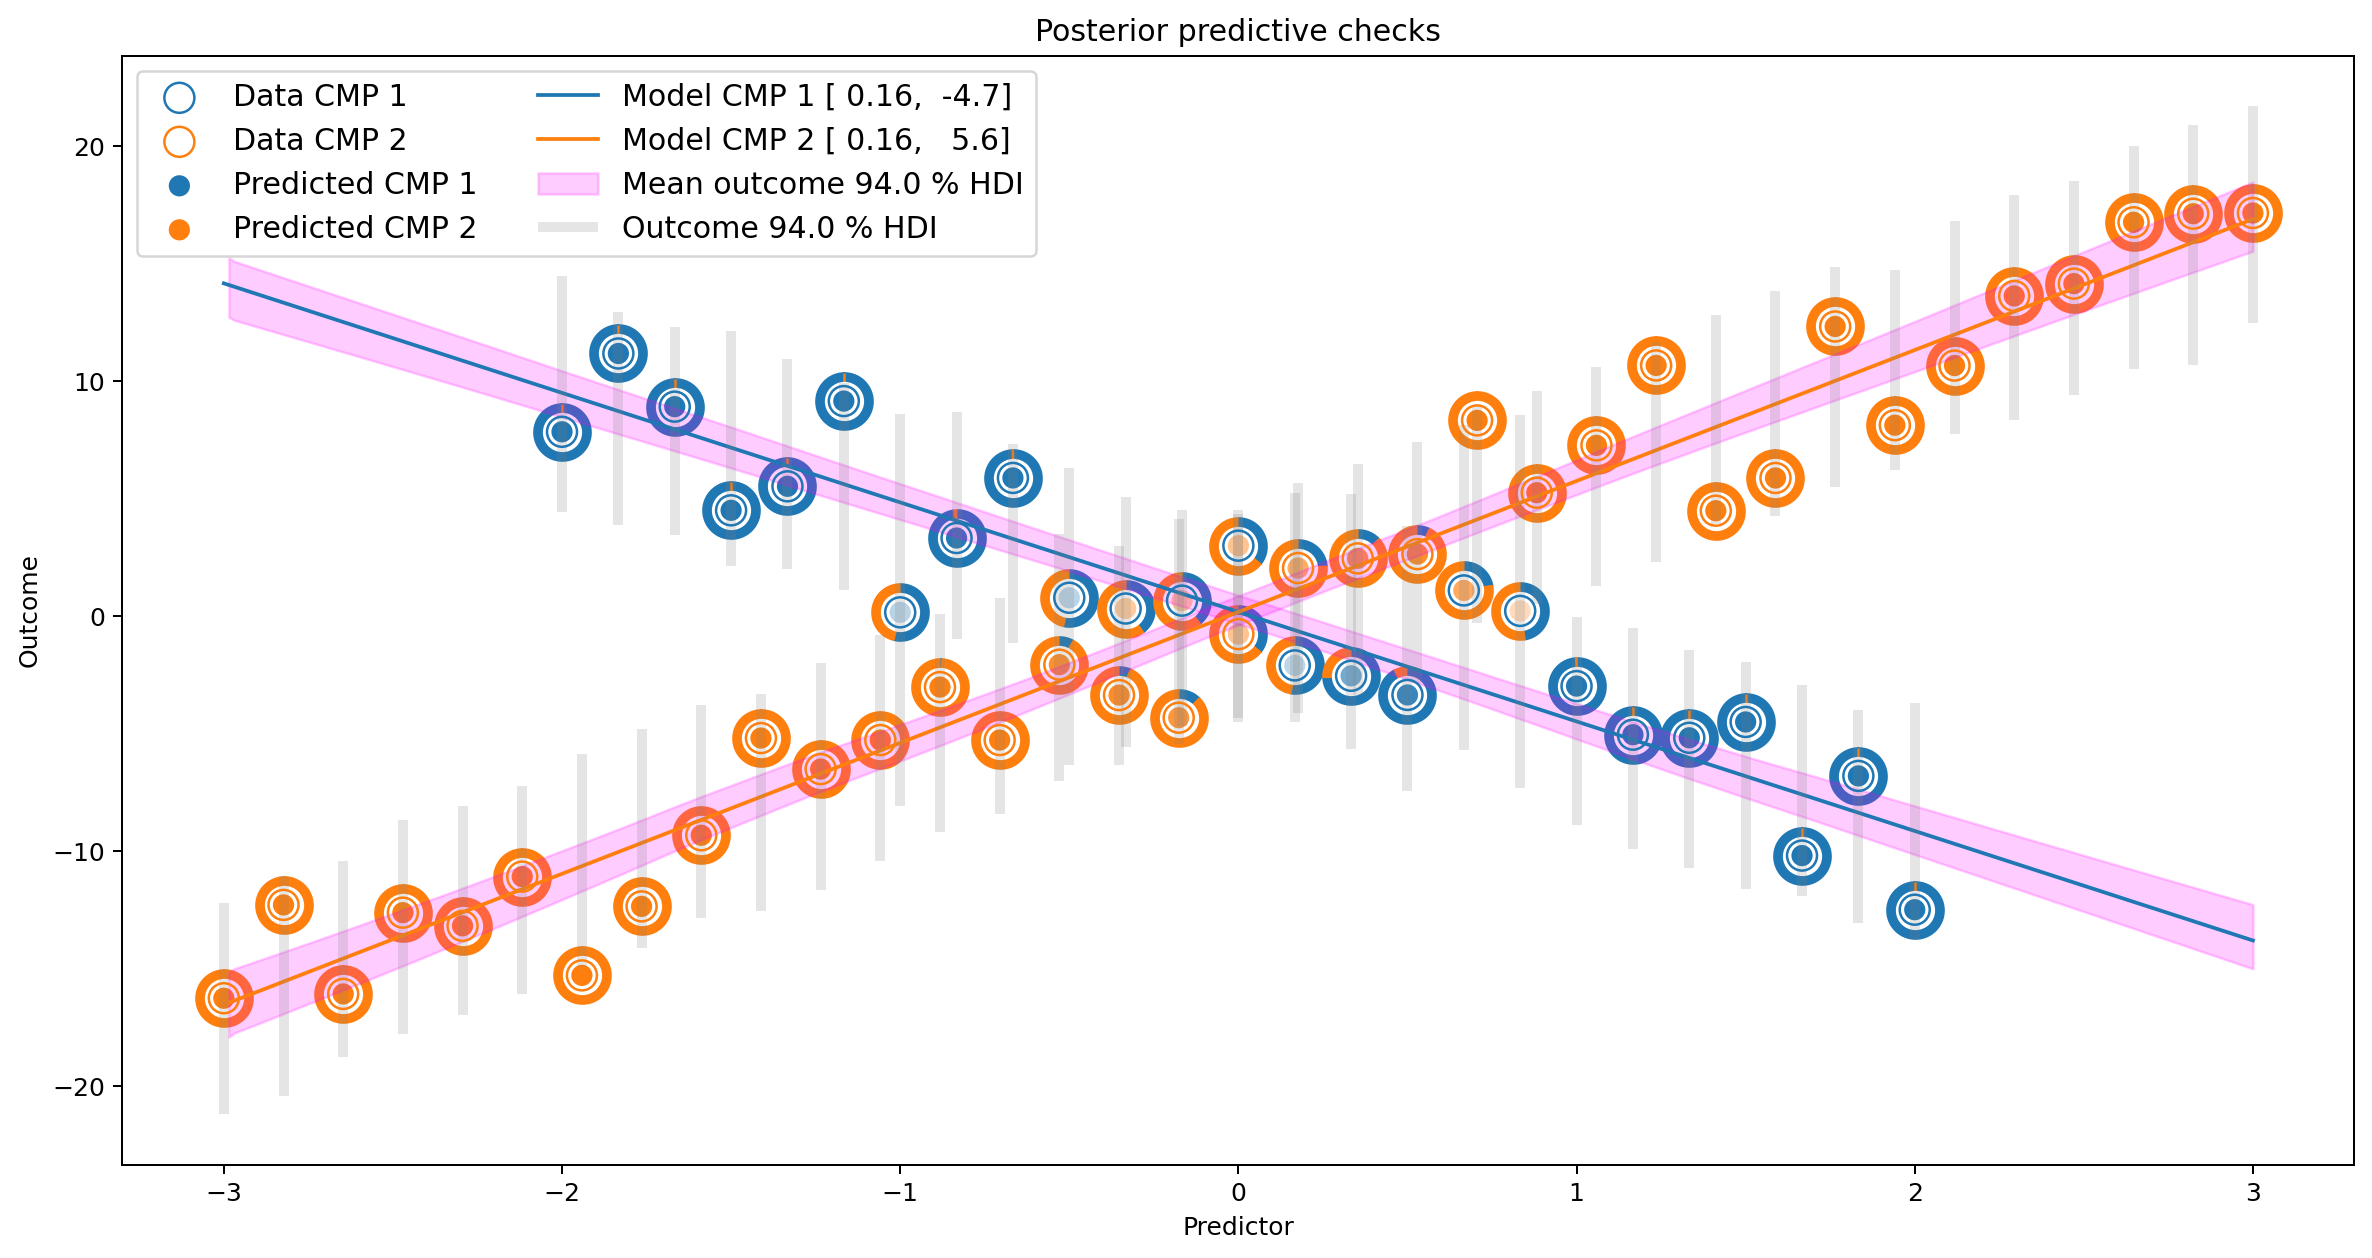

In [293]:
fig

#### Analysis: 1 component

The posterior marginal distribution for the 1-component model reveals nothing alarming, which disqualifies the model. 

0.18593670439885843
3.1581664280016617
7.4053099123539665


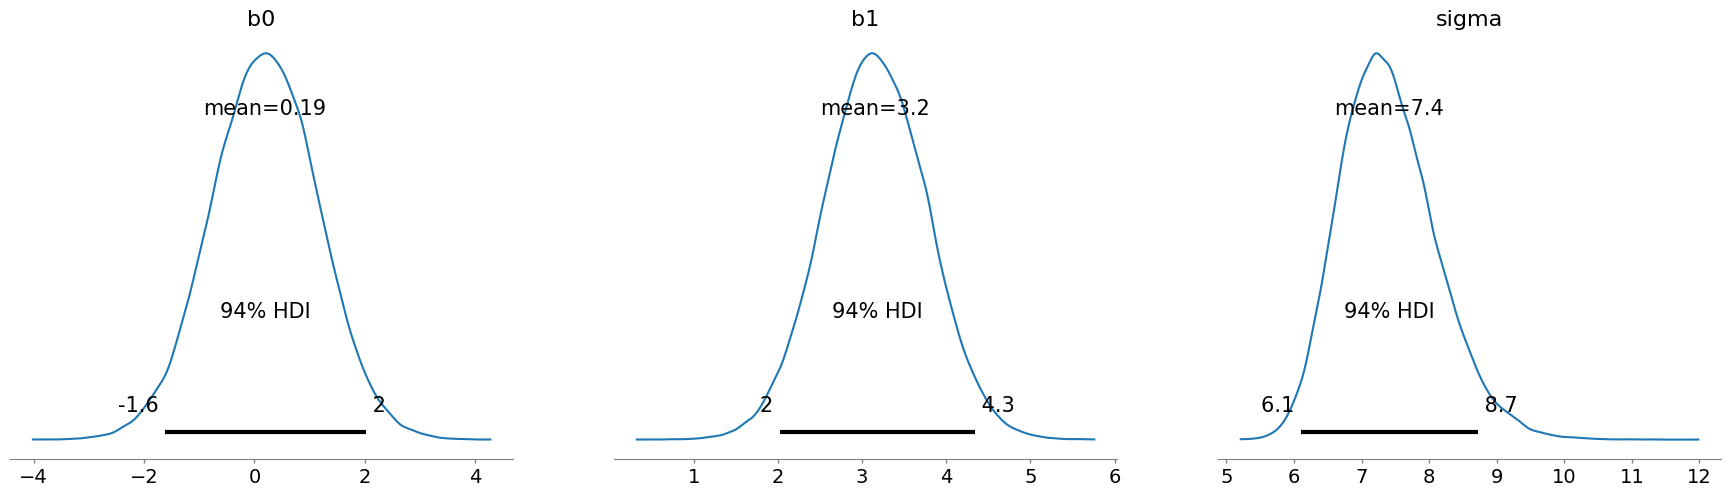

In [59]:
var_names = "b0", "b1", "sigma"
ncmp = 1
data1 = az.from_netcdf(TMP_PATH.joinpath(filename_az(ncmp, nsteps, ffc)))

# Point estimates
post = data1.posterior
b0_mean = post.mean(dim=['chain', 'draw'])["b0"].to_numpy()
b1_mean = post.mean(dim=['chain', 'draw'])["b1"].to_numpy()
sigma_mean = post.mean(dim=['chain', 'draw'])["sigma"].to_numpy()

print(b0_mean)
print(b1_mean)
print(sigma_mean)

az.plot_posterior(
    data1,
    var_names=var_names,
    point_estimate=point_estimate,
);


As expected, the mean parameter estimates are far from the true values, but obviously I cannot use that knowledge here. Below I have propagated the posterior through the model. The HDI for the outcome encompass most of the data, but judging by the eye the 1-component model does a poor job at representing the structure in the data.

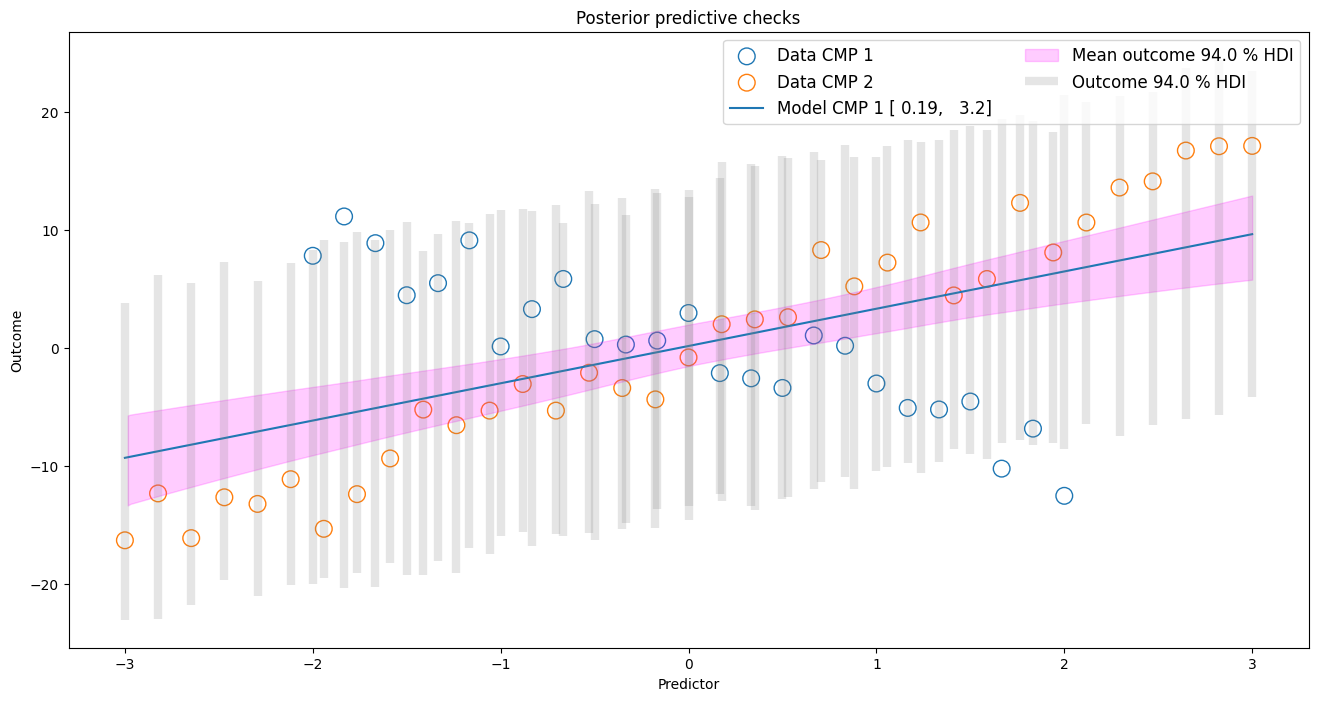

In [58]:
fig = plot_ncomp((x1, x2), (y1, y2), b0_mean, b1_mean)

ax = fig.get_axes()[0]
filepath = TMP_PATH.joinpath(filename_pymc(ncmp=1, nsteps=nsteps, ffc=False))
pymc_model = load_model(filepath)
fig = plot_ppc(data1, pymc_model, x, ax, kind="bar", samples=500, plot_mean=False)
fig

#### Analysis: 3 components

The posterior marginal distributions for the 3-component fit reveals `b1[1]` is bimodal with the two modes located close to the mean value of `b1[0]` and `b1[2]`, respectively. 

0.1695259681838338
[-5.0524462   0.48501206  5.72548434]
2.3747252624637034


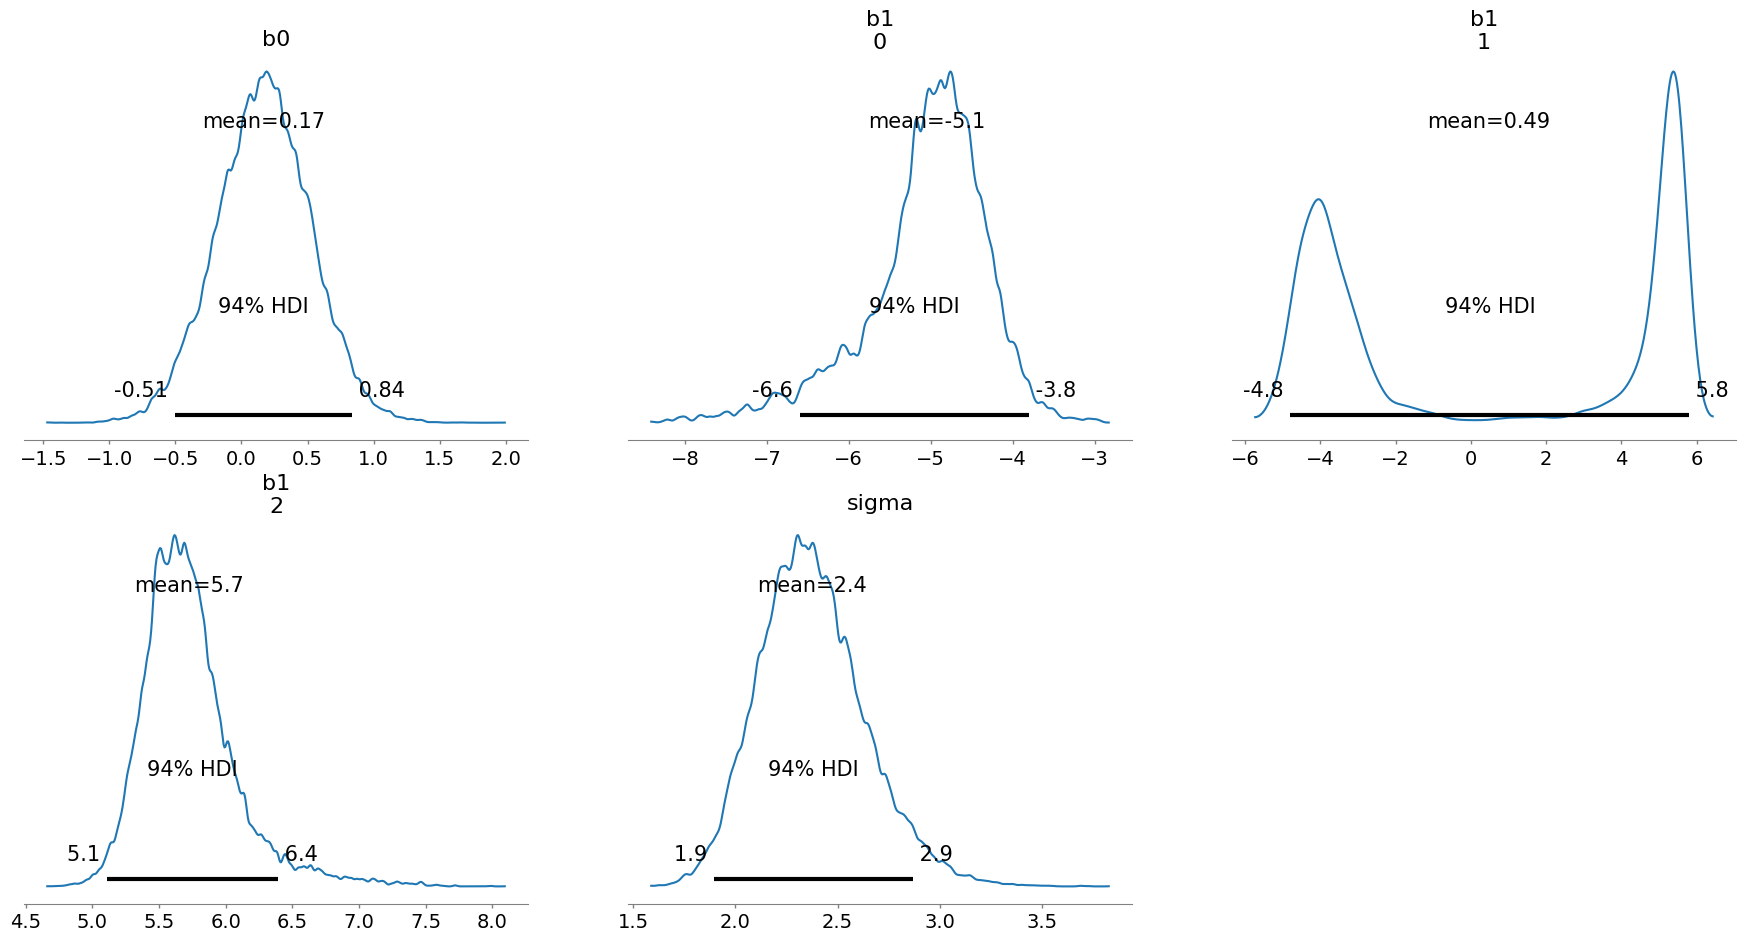

In [97]:
ncmp = 3
data3 = az.from_netcdf(TMP_PATH.joinpath(filename_az(ncmp, nsteps, ffc)))
az.plot_posterior(
    data3,
    var_names=var_names,
    point_estimate=point_estimate,
);

# Point estimates
post = data3.posterior
b0_mean = post.mean(dim=['chain', 'draw'])["b0"].to_numpy()
b1_mean = post.mean(dim=['chain', 'draw'])["b1"].to_numpy()
sigma_mean = post.mean(dim=['chain', 'draw'])["sigma"].to_numpy()

print(b0_mean)
print(b1_mean)
print(sigma_mean)

Most often for a mechanistic process described by e.g. physics, chemistry or biology I would not expect a parameter to have two states that were well-separated as is the case here. I would such a bimodal posterior to indicate flipping between two subgroups. Since the two modes of with two components. indistinguishable. Below I have propagated the posterior through the model.

Total number of draws 80000
Components weights: [0.26022958 0.24610979 0.49366063]
Filled classes [0 1 2]
Data points predominantly assigned to each class [19  2 39]


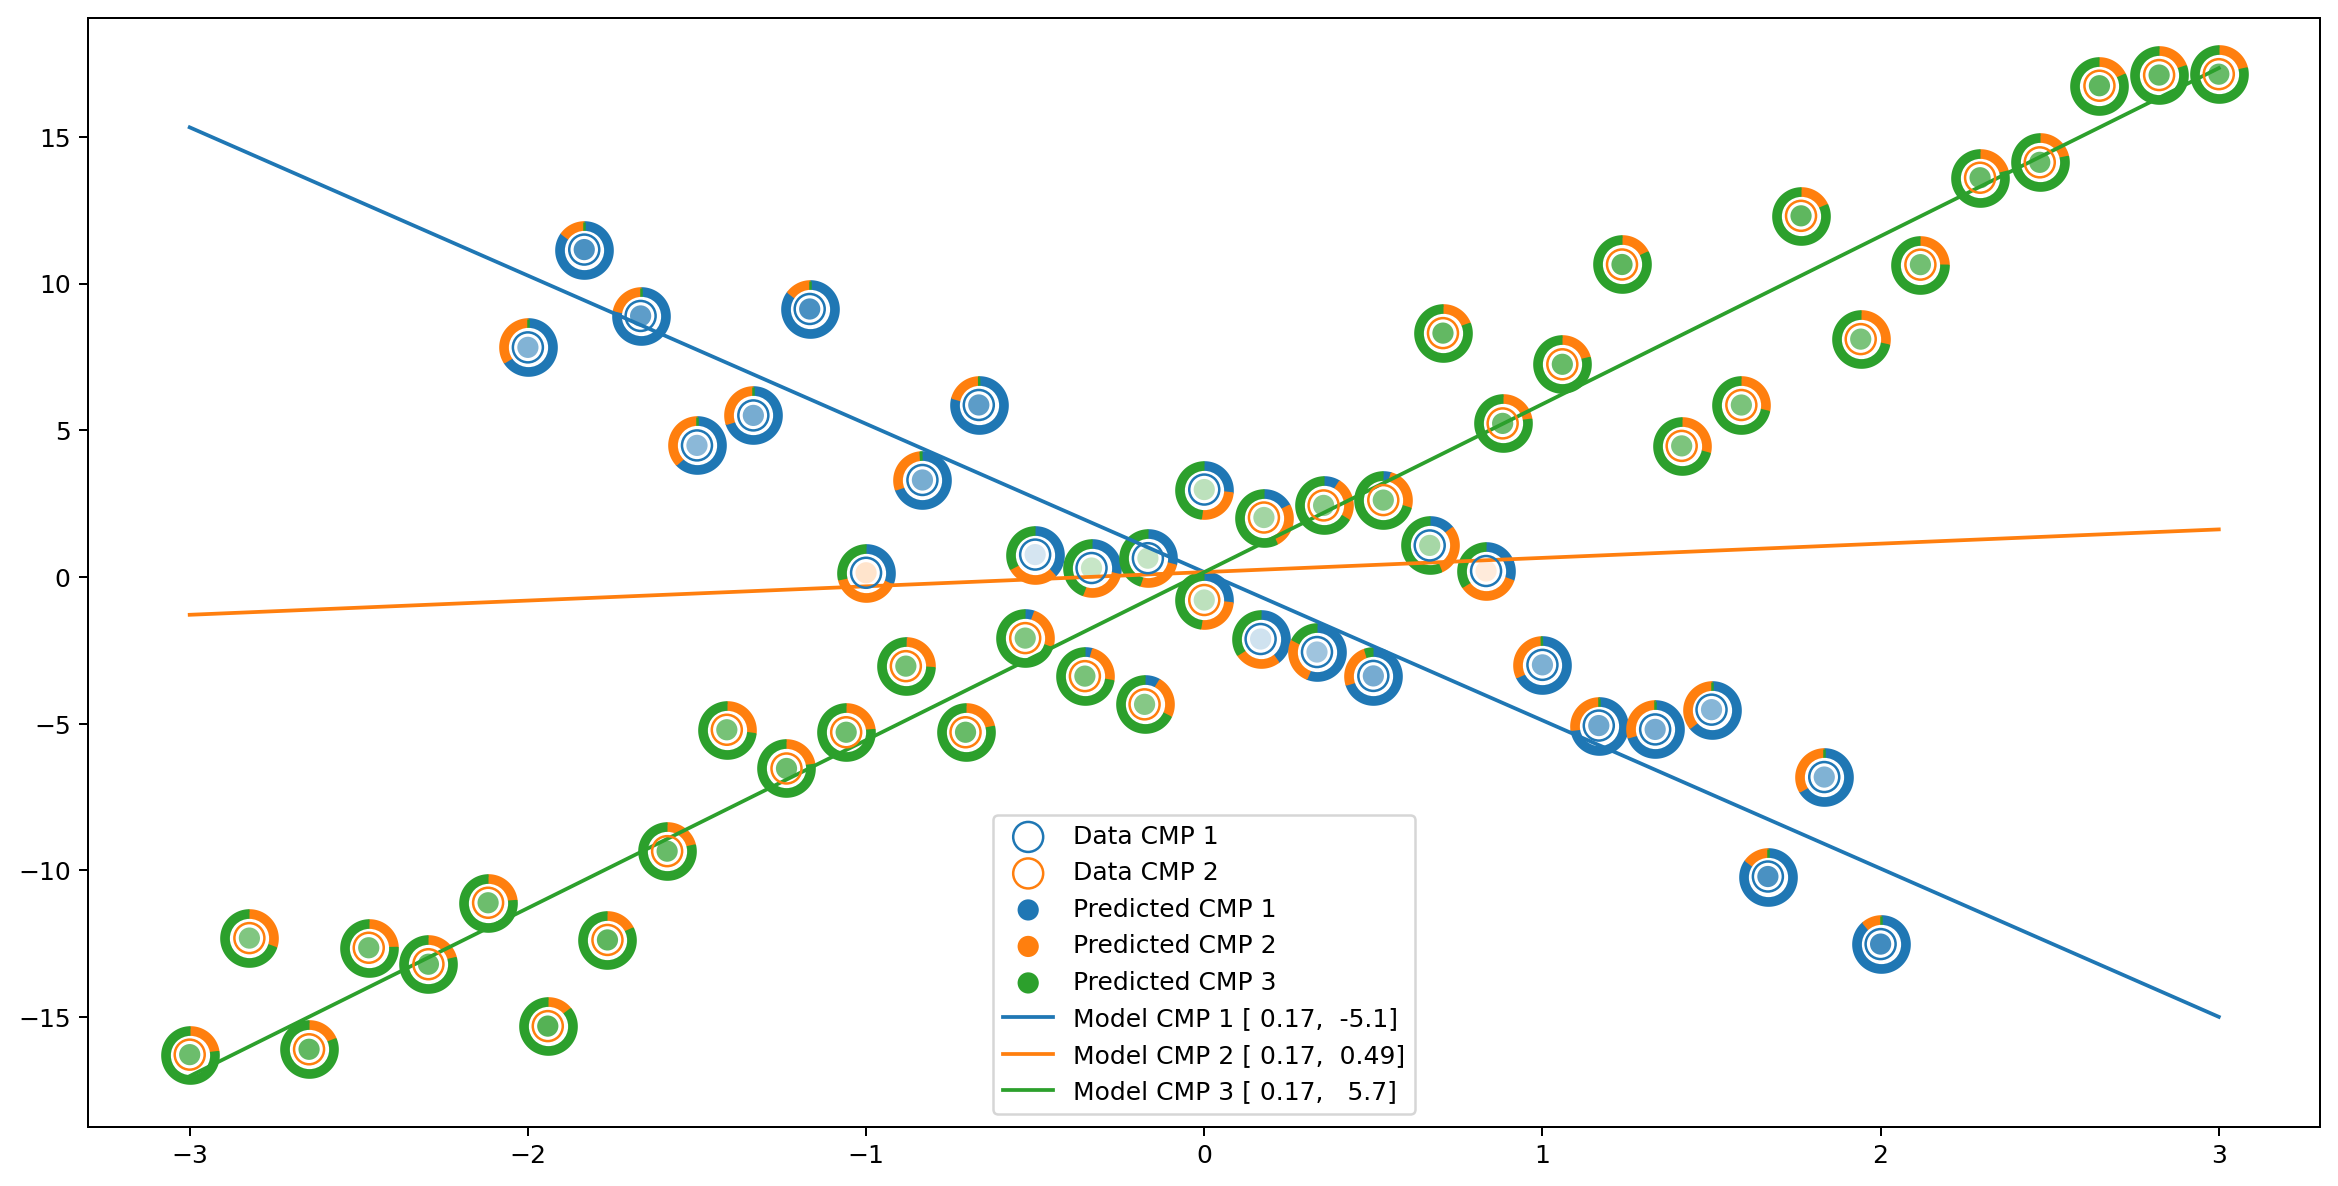

In [281]:
cat, p_cat, p_cat_all = process_posterior(post)
fig = plot_ncomp((x1, x2), (y1, y2), b0_mean, b1_mean, cat, p_cat, p_cat_all)

# HDIs do not add any insight in this case 
# filepath = TMP_PATH.joinpath(filename_pymc(ncmp=3, nsteps=nsteps, ffc=False))
# pymc_model = load_model(filepath)
# fig = plot_ppc(data3, pymc_model, x, fig.get_axes()[0], kind="scatter", samples=500, plot_mean=False)

The lines representing the mean prediction for components 1 and 3 resemble the ones predicted by the 2-component model. The third line (component 2, orange) lies in between which is to be expected from the posterior shown above. The donut chart around each data point visualizes the proportion of the total number of posterior samples where the data point belongs to a certain subgroup. We see that only two points are predominantly assigned to component 2 and for those two points the proportion of each class is very similar i.e. the subgroup assignment is not robust. All in all I would argue that the 3-component model provides no extra insight about the data compared to the 2-component model even with one additional parameter. 

I summary the posterior predictive check of the 1-component model reveals that the model does not capture the structure of the data very well. The 2-component model look fines while the 3-component model has a bimodal posterior for one of the slopes. Further, it looks like the extra component does not describe anything that was not captured by the 2-component model. 

#### Quantitative comparison

Now we can load the inference data and compare the three models using `arviz`.

> *This can be loosely interpreted as the probability of each model (among the compared model)*

https://python.arviz.org/en/v0.12.1/api/generated/arviz.compare.html

https://discourse.pymc.io/t/dic-waic-wbic-on-regression-tasks/247/5


In [184]:
ncmps = [1, 2, 3]
idata = {}
for ncmp in ncmps:
    idata[f"cmp {ncmp}"] = az.from_netcdf(TMP_PATH.joinpath(filename_az(ncmp, nsteps, ffc)))

# az.loo(idata["cmp 3"])

In [179]:
method = "stacking"
# method = "BB-pseudo-BMA"
# method = "pseudo-BMA"
df_compare_loo = az.compare(idata, ic="loo", seed=RANDOM_SEED, method=method)
print(df_compare_loo)
# ax = az.plot_compare(df_compare_loo, insample_dev=False)


/home/jacob/.local/share/virtualenvs/misc-VgmIW_Et/lib/python3.8/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/jacob/.local/share/virtualenvs/misc-VgmIW_Et/lib/python3.8/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/jacob/.local/share/virtualenvs/misc-VgmIW_Et/lib/python3.8/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/jacob/.local/share/virtualenvs/misc-VgmIW_Et/lib/python3.8/site-p

       rank         loo      p_loo      d_loo        weight        se  \
cmp 2     0 -147.411507  13.157490   0.000000  7.000818e-01  4.787060   
cmp 3     1 -148.837414  16.528229   1.425907  2.999182e-01  5.858641   
cmp 1     2 -206.720585   3.373347  59.309077  8.292427e-20  4.891173   

            dse  warning loo_scale  
cmp 2  0.000000     True       log  
cmp 3  2.046367     True       log  
cmp 1  7.391290    False       log  


In [180]:
df_compare_waic = az.compare(idata, ic="waic", seed=RANDOM_SEED, method=method)
print(df_compare_waic)
# ax = az.plot_compare(df_compare_waic, insample_dev=False)


/home/jacob/.local/share/virtualenvs/misc-VgmIW_Et/lib/python3.8/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/jacob/.local/share/virtualenvs/misc-VgmIW_Et/lib/python3.8/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


       rank        waic    p_waic     d_waic        weight        se  \
cmp 2     0 -141.656312  7.402295   0.000000  5.730409e-01  4.011174   
cmp 3     1 -141.959746  9.650560   0.303434  4.269591e-01  5.852365   
cmp 1     2 -206.702711  3.355473  65.046399  1.548112e-22  4.103253   

            dse  warning waic_scale  
cmp 2  0.000000     True        log  
cmp 3  0.195360     True        log  
cmp 1  6.795412     True        log  


/home/jacob/.local/share/virtualenvs/misc-VgmIW_Et/lib/python3.8/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


### Unspecified number of mixture components 


Automatically determine the number of classes using a Dirichlet prior with $1/H$ does not give good results. Gelman et al. [[3]](#3).

prior that should favor populating few dominant components. See appendix

scikit learn docs [[4]](#4)

‘dirichlet_distribution’}
weight_concentration_prior
’s set to 1. / n_components.

# Appendix

## Clustering

Try some clustering methods from `sklearn`. I have only a quite limited subset of clustering algorithms and I have not tweaked any parameters since the purpose is not to present an exhaustive comparison their performance, but rather to get an idea about their qualitative properties. 

### K-means

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py


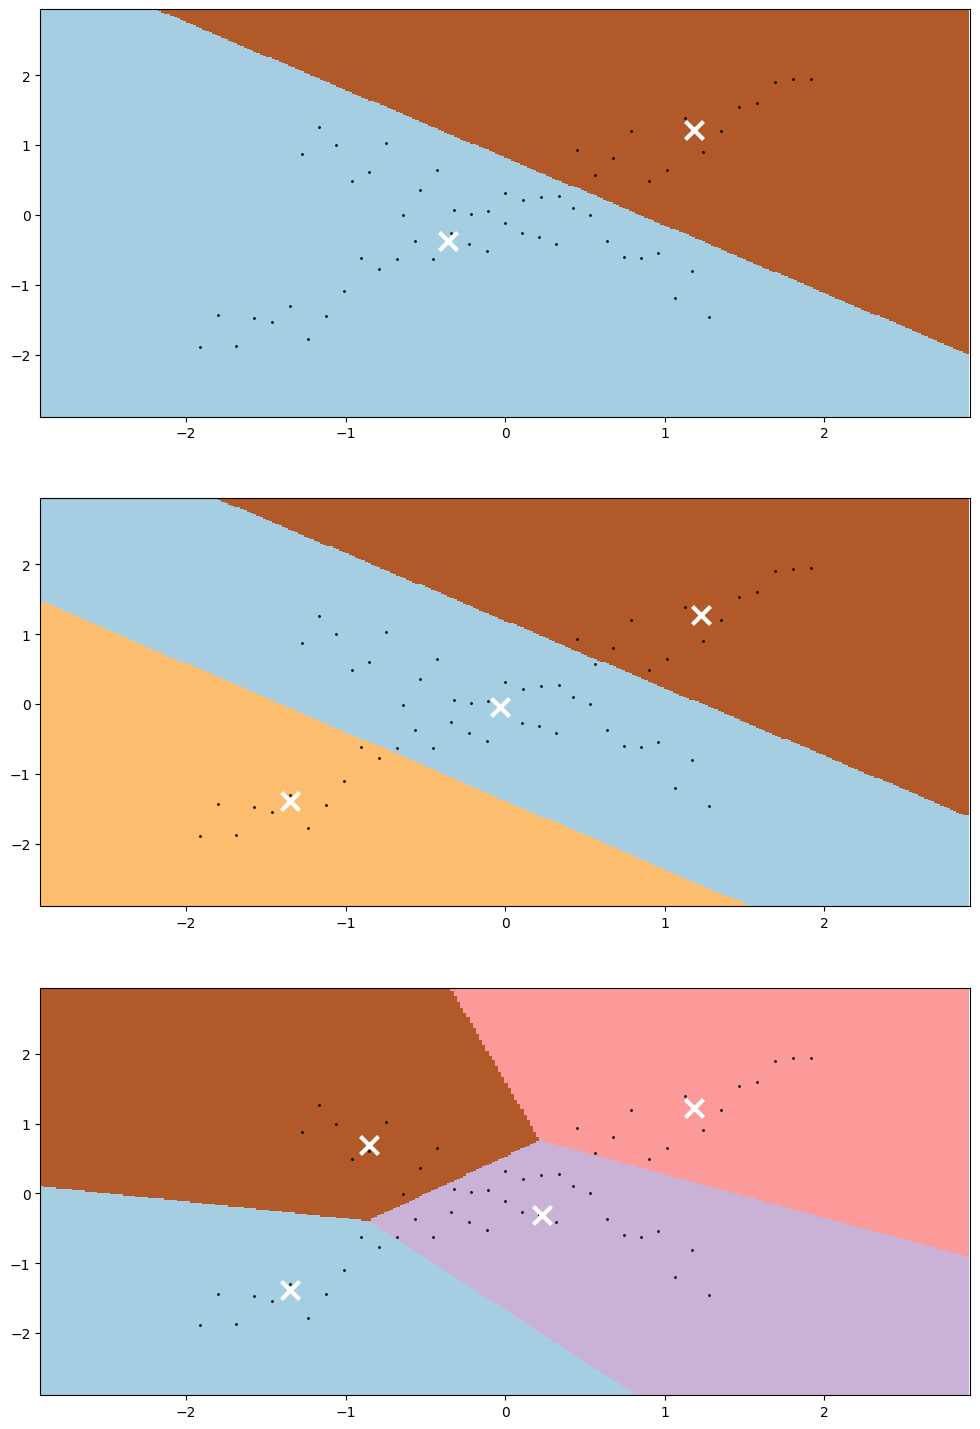

In [93]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def plot_k_means(xy, ax, kmeans):
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = xy[:, 0].min() - 1, xy[:, 0].max() + 1
    y_min, y_max = xy[:, 1].min() - 1, xy[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect="auto",
        origin="lower",
    )

    ax.plot(xy[:, 0], xy[:, 1], "k.", markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    ax.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=169,
        linewidths=3,
        color="w",
        zorder=10,
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

n_clusters = [2, 3, 4]
xy = np.stack((x, y), axis=1)
fig, axs = plt.subplots(len(n_clusters), figsize=(12,18))
scaler = StandardScaler()
scaler.fit(xy)
xy_ = scaler.transform(xy)

for n, ax in zip(n_clusters, axs):
    kmeans = KMeans(init="k-means++", n_clusters=n, n_init=4)
    labels = kmeans.fit_predict(xy_)
    plot_k_means(xy_, ax, kmeans)

###  GaussianMixture

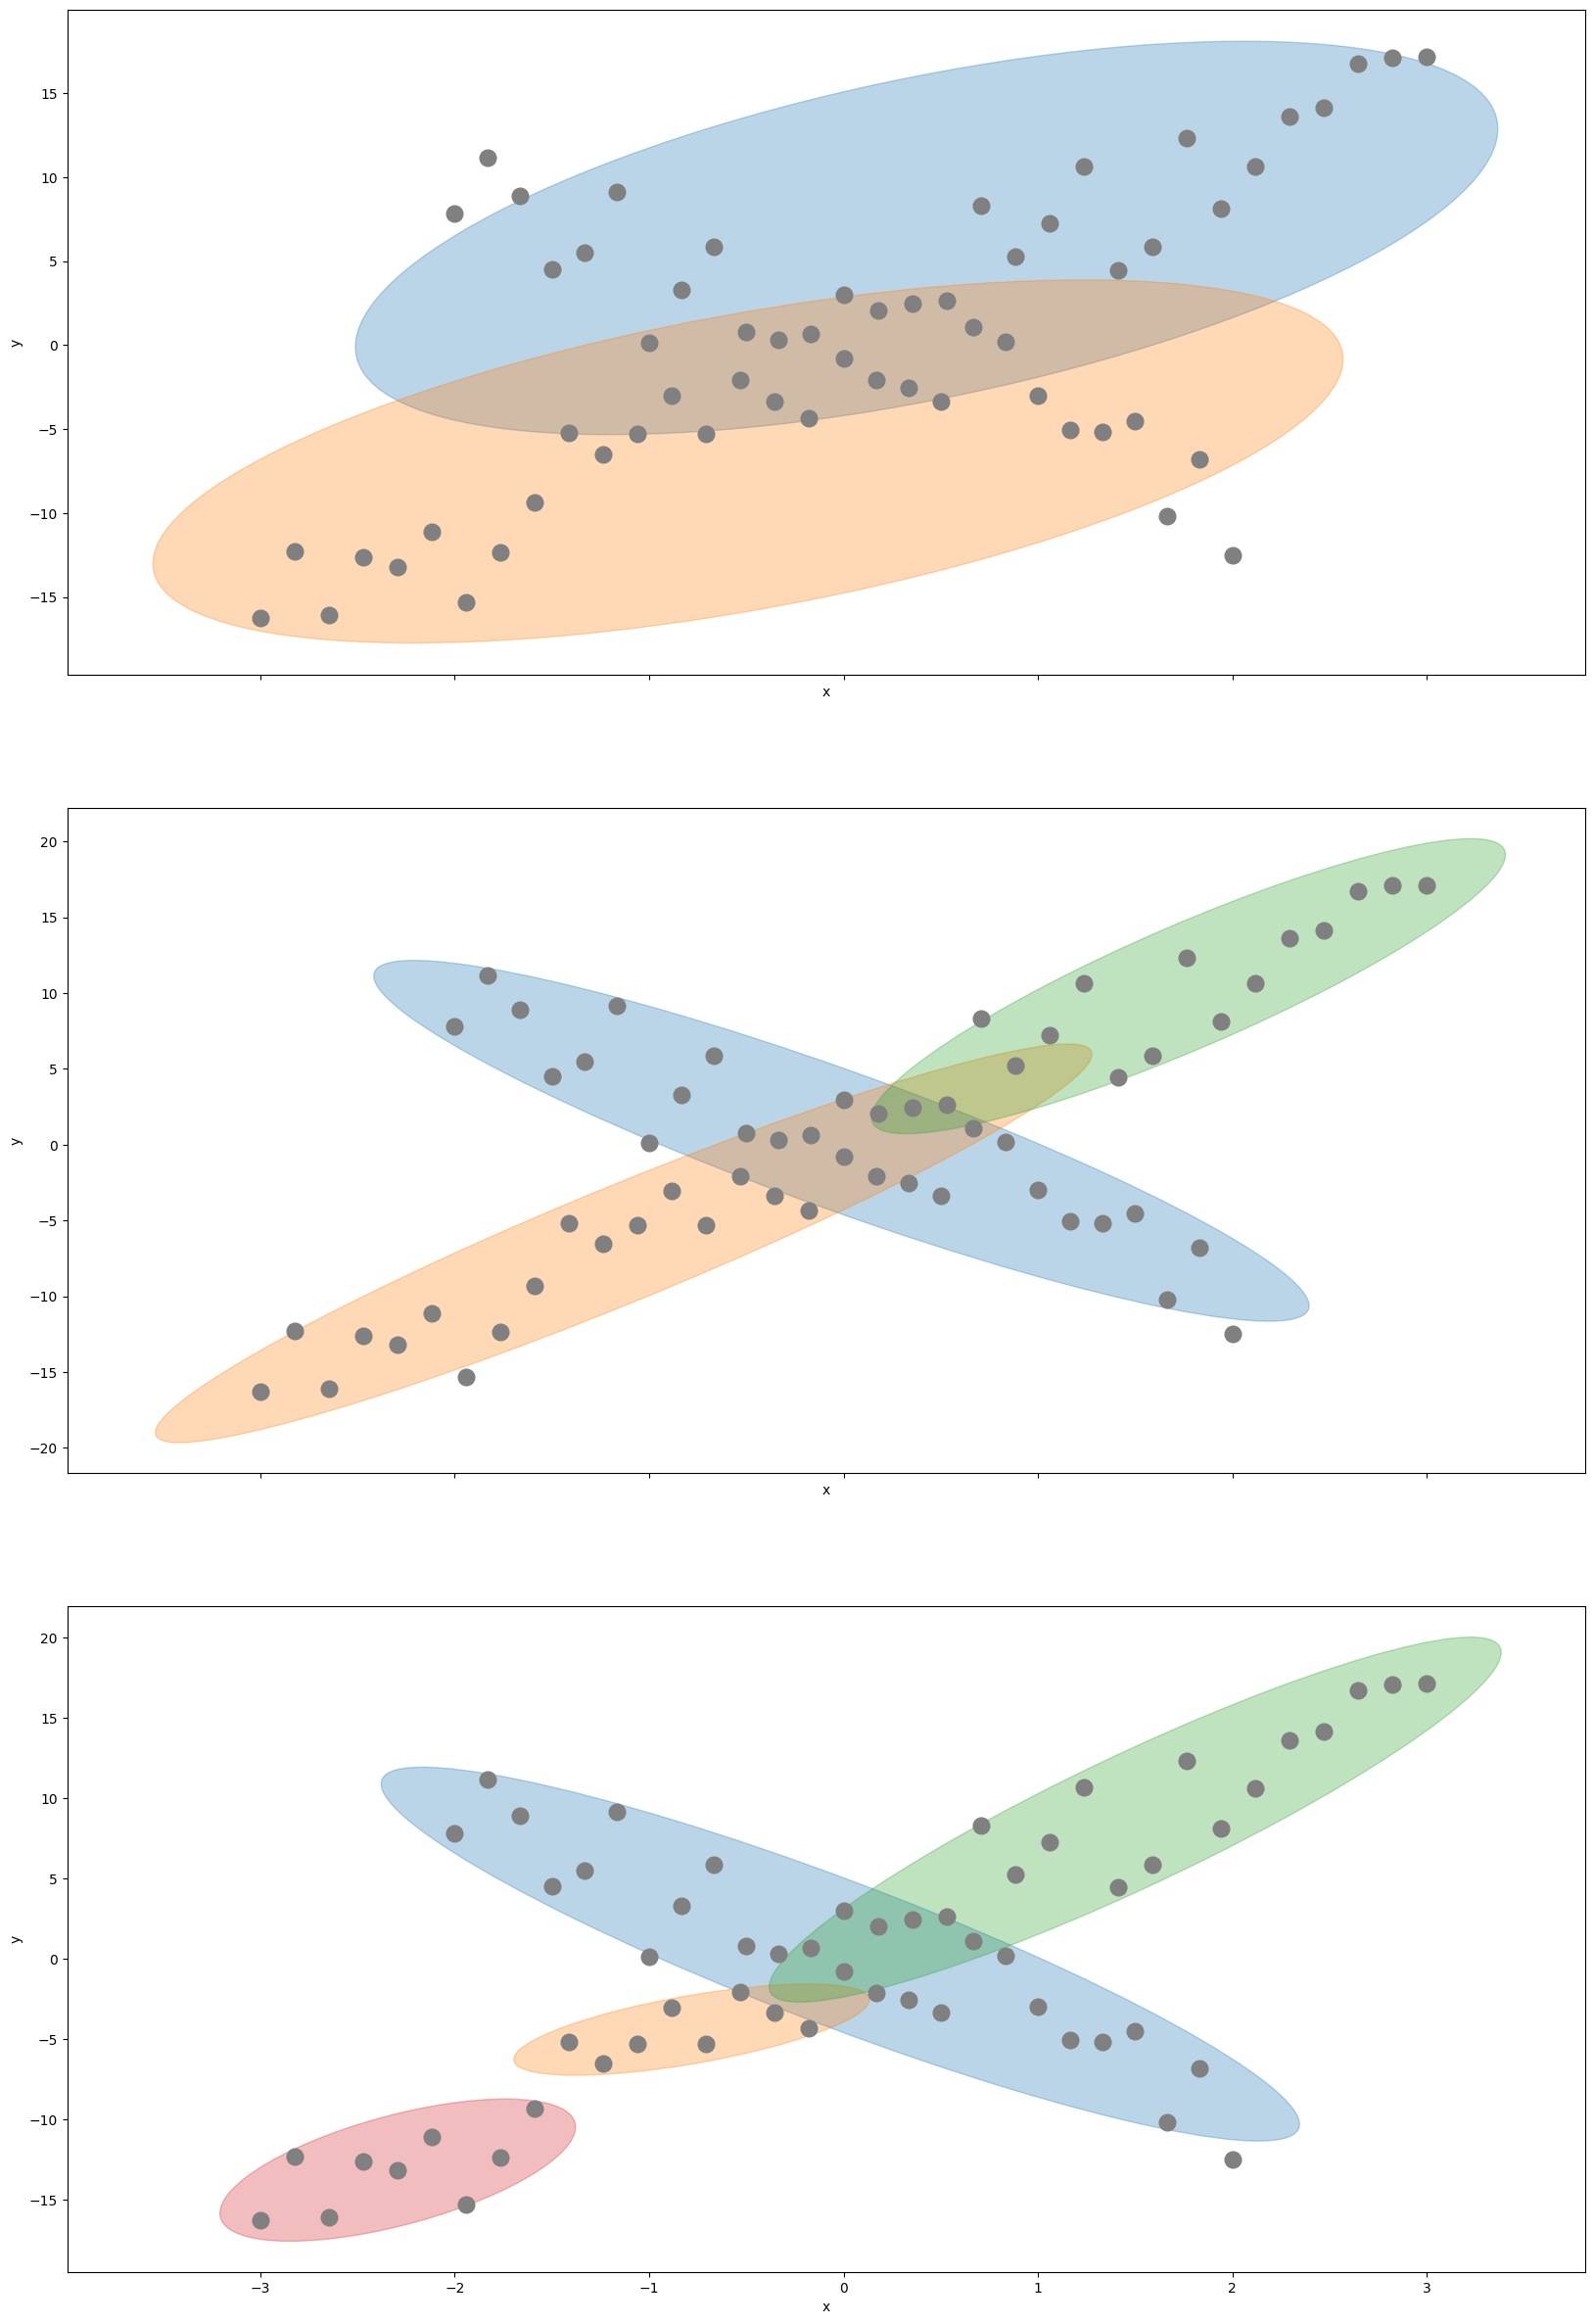

In [14]:
from two_models import plot_cov_ellipse
from sklearn.preprocessing import StandardScaler


def gmm(xy, ax):
    clsfier = GaussianMixture(
        n_components=n_components,
        random_state=RANDOM_SEED,
    )

    labels = clsfier.fit_predict(xy)

    means = clsfier.means_
    covs = clsfier.covariances_
    label_ids = set(labels)

    # ax.set_title(f"BayesianGaussianMixture with {n_components_gmm} initial components")
    ax.scatter(
        xy[:,0],
        xy[:,1],
        s=144,
        marker="o",
        edgecolor="gray",
        facecolor="gray",
    )
    for mean, cov, color, label in zip(means, covs, colors, label_ids):
        plot_cov_ellipse(cov, mean, nstd=2, ax=axs[i], color=color, zorder=-1000, alpha=0.3)


    ax.set_ylabel("y")
    ax.set_xlabel("x")


n_components_gmm = [2, 3, 4]
xy = np.stack((x, y), axis=1)
fig, axs = plt.subplots(3, 1, figsize=(20, 30), sharex=True)
colors = get_cmap(CMAP_NAME).colors
# scaler = StandardScaler()
# scaler.fit(xy)
# xy_ = scaler.transform(xy)


for i, n_components in enumerate(n_components_gmm):
    gmm(xy, axs[i])


## Dirichlet distribution

Below I have illustrated the Dirichlet distribution for three categories. The code is modified from [this](https://github.com/yusueliu/medium/blob/master/scripts/plot_dirichlet.py) repository. See also [this](https://medium.com/towards-data-science/dirichlet-distribution-a82ab942a879) blog. For the present application I am using the Dirichlet prior [since](https://en.wikipedia.org/wiki/Dirichlet_distribution) 

> *Dirichlet distribution is the conjugate prior of the categorical distribution and multinomial distribution.*

I am only using the symmetric Dirichlet distribution which [Wikipedia](https://en.wikipedia.org/wiki/Dirichlet_distribution) describes as

> *The simplest and perhaps most common type of Dirichlet prior is the symmetric Dirichlet distribution, where all parameters are equal. This corresponds to the case where you have no prior information to favor one component over any other.*

I have shown the flat distribution Dirichlet(1, 1, 1) which is considered an uninformative prior and tends to populate (assign weight) to many  components according to Gelman et al. [[3]](#3) (p536). The other distribution shown Dirichlet(0.33, 0.33, 0.33) will tend toward a few high probability components and the remaining components having a small probability. 

2.0
24.52229461980122
2.0
24.595588632643214


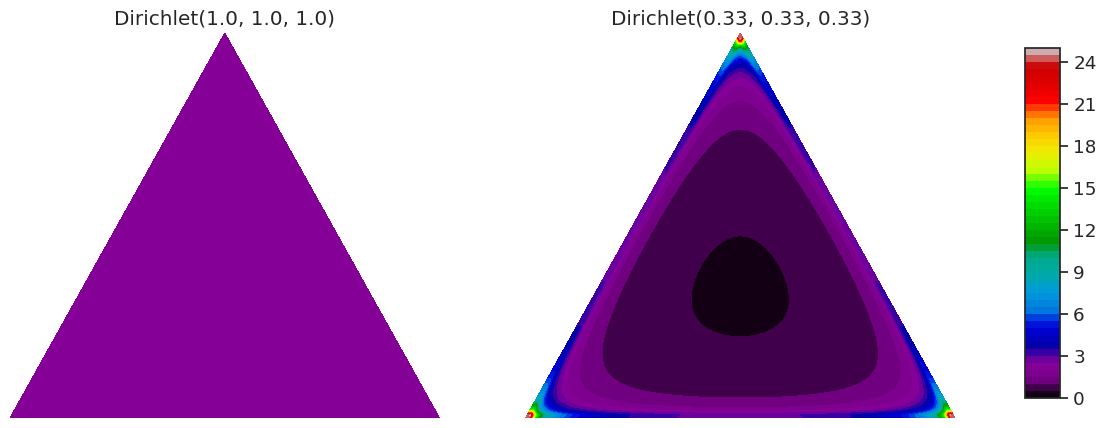

In [123]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import seaborn as sns
from math import gamma
from operator import mul
from functools import reduce
from scipy.stats import dirichlet

sns.set(style='white', font_scale=1.2, font='consolas')

def plot_mesh(corners):
    """Subdivide the triangle into a triangular mesh and plot the original and subdivided triangles."""
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=4)
    
    plt.figure(figsize=(6, 4))
    for i, mesh in enumerate((triangle, trimesh)):
        plt.subplot(1, 2, i+1)
        plt.triplot(mesh)
        plt.axis('off')
        plt.axis('equal')    
        
        
class Dirichlet:
    """Define the Dirichlet distribution with vector parameter alpha."""
    def __init__(self, alpha):
        
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / reduce(mul, [gamma(a) for a in self._alpha])
    
    def pdf(self, x):
        """Returns pdf value for `x`. """
        return self._coef * reduce(mul, [xx ** (aa-1) for (xx, aa) in zip(x, self._alpha)])
        
        
class PlotDirichlet:
    """
    Plot the Dirichlet distribution as a contour plot on a 2-Simplex.
    """
    def __init__(self, corners):
        self._corners = corners
        self._triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
        # Midpoints of triangle sides opposite of each corner
        self._midpoints = [(corners[(i+1) % 3] + corners[(i+2) % 3]) / 2.0 for i in range(3)]
        
    def xy2bc(self, xy, tol=1.e-3):
        """Map the x-y coordinates of the mesh vertices to the simplex coordinate space (aka barycentric coordinates).
        Here we use a simple method that uses vector algebra. For some values of alpha, calculation of the Dirichlet pdf 
        can become numerically unstable at the boundaries of the simplex so our conversion function will take an optional 
        tolerance that will avoid barycentric coordinate values directly on the simplex boundary.        
        """
        s = [(self._corners[i] - self._midpoints[i]).dot(xy - self._midpoints[i]) / 0.75 for i in range(3)]
        return np.clip(s, tol, 1.0-tol)
        
    def draw_pdf_contours(self, ax, dist, label=None, nlevels=200, levels=None, subdiv=8, **kwargs):
        """Draw pdf contours for a Dirichlet distribution"""
        # Subdivide the triangle into a triangular mesh
        refiner = tri.UniformTriRefiner(self._triangle)
        trimesh = refiner.refine_triangulation(subdiv=subdiv)
        # convert to barycentric coordinates and compute probabilities of the given distribution 
        pvals = [dist.pdf(self.xy2bc(xy, tol=1e-2)) for xy in zip(trimesh.x, trimesh.y)]
        print(max(pvals))
    
        tcf = ax.tricontourf(trimesh, pvals, cmap=cmap, levels=levels)
        #plt.axis('equal')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 0.75**0.5)
        ax.set_title(str(label))
        ax.axis('off') 
        return ax, tcf


corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
plot_dirichlet = PlotDirichlet(corners)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cmap = get_cmap("nipy_spectral")
ax = axes[0]
alpha = (1.0, 1.0, 1.0)
dist = Dirichlet(alpha)
label = f"Dirichlet{alpha}"
ax, tcf = plot_dirichlet.draw_pdf_contours(ax, dist, label=label, cmap=cmap, levels=np.linspace(0,25,51))

ax = axes[1]
alpha = (0.33, 0.33, 0.33)
dist = Dirichlet(alpha)
label = f"Dirichlet{alpha}"
ax, tcf = plot_dirichlet.draw_pdf_contours(ax, dist, label=label, cmap=cmap, levels=np.linspace(0,25,51))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
fig.colorbar(tcf, cax=cbar_ax);


# Examples using scipy
quantiles = np.array([0.1, 0.3, 0.6])  # specify quantiles
alpha = np.array([1, 1, 1])  # specify concentration parameters
print(dirichlet.pdf(quantiles, alpha))

tol = 1e-2
quantiles = np.array([1.0 - 2*tol, tol, tol])  # specify quantiles
alpha = np.array([0.33, 0.33, 0.33])  # specify concentration parameters
print(dirichlet.pdf(quantiles, alpha))


In [169]:
%watermark  -n -u -v -iv -w

Last updated: Fri Jan 20 2023

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 8.7.0

seaborn   : 0.11.2
theano    : 1.1.2
pymc3     : 3.11.5
numpy     : 1.22.1
matplotlib: 3.5.3
pandas    : 1.4.3
arviz     : 0.12.1
ipykernel : 6.19.4
debugpy   : 1.6.4
sys       : 3.8.10 (default, Jun 22 2022, 20:18:18) 
[GCC 9.4.0]

Watermark: 2.3.1

